# Download Data (Optional)

In [ ]:
import os
import sys
# check if we are in google colab
try:
    import google.colab
    from google.colab import drive
    drive.mount('/content/drive')
    base_path = '/content/drive/MyDrive'
except:
    base_path = os.path.join(os.getcwd(), 'data')
if not (os.path.exists(base_path)):
    os.mkdir(base_path)

path_2016_data = os.path.join(base_path, 'data_2016.csv')
path_2017_data = os.path.join(base_path, 'data_2017.csv')



# Download data_2016.csv from the internet
if not os.path.exists(path_2016_data):
    print("Downloading data_2016.csv from the internet")
    url = 'https://health.data.ny.gov/api/views/gnzp-ekau/rows.csv?accessType=DOWNLOAD'
    !curl -o $path_2016_data $url --progress-bar

# Download data_2017.csv from the internet
if not os.path.exists(path_2017_data):
    print("Downloading data_2017.csv from the internet")
    url = 'https://health.data.ny.gov/api/views/22g3-z7e7/rows.csv?accessType=DOWNLOAD'
    !curl -o $path_2017_data $url --progress-bar


Mounted at /content/drive


# Descriptive Stats (Optional)
Don't run this block if you don't want to clog up the memory. This block loads the entire dataset into memory

## Imports

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as sch
from torch.utils.data import Dataset,DataLoader, random_split
import math
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from collections import defaultdict

## Stats and Plots

In [ ]:
df = pd.read_csv(path_2016_data)

In [ ]:
df.loc[:, 'Length of Stay'] = df['Length of Stay'].replace('120 +',120)
df.loc[:, 'Length of Stay'] = df['Length of Stay'].astype(int)

In [ ]:
df["Length of Stay"].describe()

In [ ]:
df[df['Type of Admission'] != 'Newborn']["Length of Stay"].describe()

count    2.118650e+06
mean     5.584255e+00
std      7.928658e+00
min      1.000000e+00
25%      2.000000e+00
50%      3.000000e+00
75%      6.000000e+00
max      1.200000e+02
Name: Length of Stay, dtype: float64

In [ ]:
df[df['Type of Admission'] == 'Newborn']['Length of Stay'].describe()

count    224779.000000
mean          3.750346
std           8.117786
min           1.000000
25%           2.000000
50%           2.000000
75%           3.000000
max         120.000000
Name: Length of Stay, dtype: float64

<Axes: ylabel='Density'>

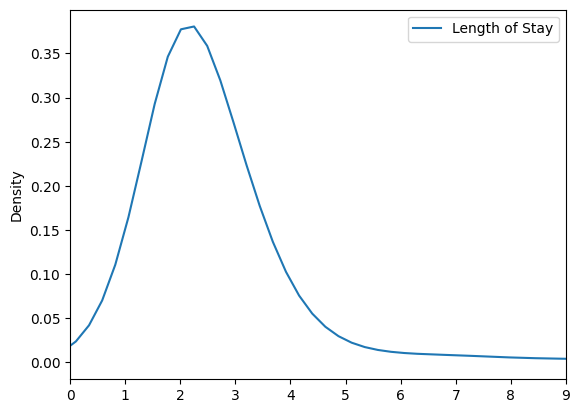

In [ ]:
df[df['Type of Admission'] == 'Newborn'].plot(y='Length of Stay', kind='density', xlim = (0, 9))

<Axes: title={'center': 'Length of Stay for Newborns'}, xlabel='Length of Stay', ylabel='Frequency'>

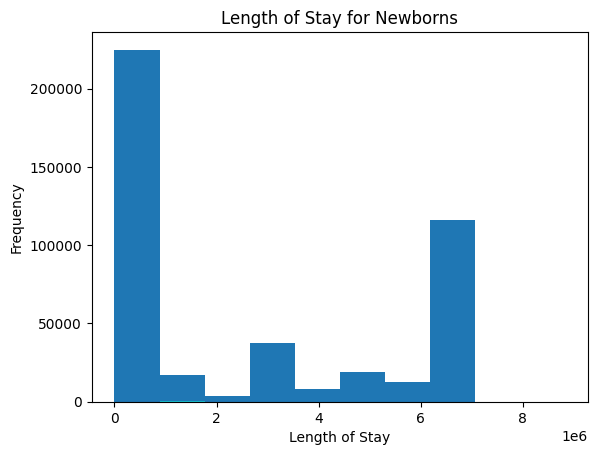

In [ ]:
ax = df[df['Type of Admission']=='Newborn'].plot(x='Length of Stay', kind='hist')
ax.set_xlabel("Length of Stay")
ax.set_title("Length of Stay for Newborns")
ax.legend_.remove()
ax

In [ ]:
freq_counts = df[df['Type of Admission'] == 'Newborn']["Length of Stay"].value_counts()
freq_counts_frac = freq_counts / freq_counts.sum()
freq_counts_frac.head()


2    0.540838
3    0.246918
1    0.066189
4    0.060086
5    0.015816
Name: Length of Stay, dtype: float64

In [ ]:
df.describe()

,Operating Certificate Number,Facility Id,Length of Stay,Discharge Year,CCS Diagnosis Code,CCS Procedure Code,APR DRG Code,APR MDC Code,APR Severity of Illness Code,Birth Weight,Total Charges,Total Costs
count,2.338104e+06,2.338104e+06,2.343429e+06,2343429.0,2.343429e+06,2.343429e+06,2.343429e+06,2.343429e+06,2.343429e+06,2.343429e+06,2.343429e+06,2.343429e+06
mean,4.989377e+06,1.040337e+03,5.408348e+00,2016.0,1.906030e+02,1.046221e+02,4.165046e+02,1.032289e+01,2.024331e+00,3.190755e+02,4.600403e+04,1.572127e+04
std,2.265922e+06,7.182711e+02,7.965321e+00,0.0,1.613759e+02,8.958427e+01,2.425629e+02,5.898533e+00,9.025603e-01,9.788713e+02,8.733740e+04,3.159174e+04
min,1.010000e+05,1.000000e+00,1.000000e+00,2016.0,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e-02,0.000000e+00
25%,2.951001e+06,5.410000e+02,2.000000e+00,2016.0,1.050000e+02,0.000000e+00,1.980000e+02,5.000000e+00,1.000000e+00,0.000000e+00,1.268573e+04,4.626490e+03
50%,5.907001e+06,1.097000e+03,3.000000e+00,2016.0,1.570000e+02,1.080000e+02,3.830000e+02,9.000000e+00,2.000000e+00,0.000000e+00,2.488900e+04,8.660520e+03
75%,7.002017e+06,1.450000e+03,6.000000e+00,2016.0,2.180000e+02,1.980000e+02,6.400000e+02,1.500000e+01,3.000000e+00,0.000000e+00,4.938439e+04,1.671171e+04
max,7.004010e+06,9.431000e+03,1.200000e+02,2016.0,9.990000e+02,9.990000e+02,9.560000e+02,2.500000e+01,4.000000e+00,9.000000e+03,1.047750e+07,5.870820e+06


### Plot length of stay

In [ ]:
df["APR DRG Code"].value_counts()

640    195238
560    142275
720     93349
540     74561
194     56708
        ...  
841        47
6          47
583        46
95         46
956        14
Name: APR DRG Code, Length: 316, dtype: int64

<ipython-input-12-c4e38a5bb99f>:56: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


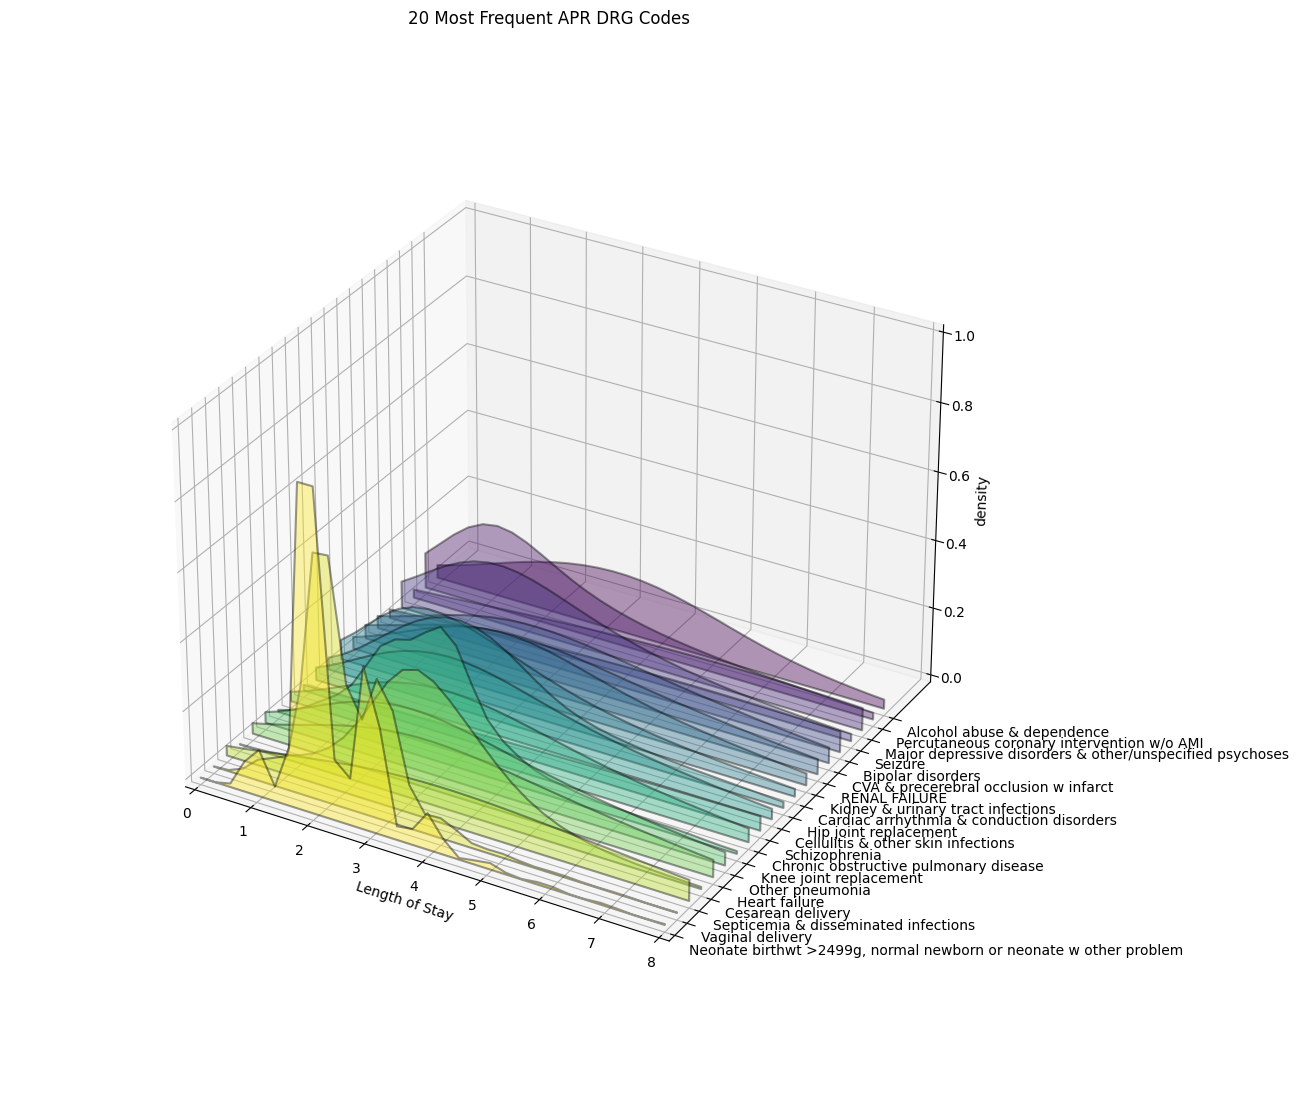

In [ ]:
import math

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

from matplotlib.collections import PolyCollection

# Fixing random state for reproducibility
np.random.seed(19680801)

def polygon_under_graph(x_first, x_last, points, l):
    """
    Construct the vertex list which defines the polygon filling the space under
    the (x, y) line graph. This assumes x is in ascending order.
    """

    input_data = df[df["APR DRG Description"]==l]["Length of Stay"].values
    kde = gaussian_kde(input_data, bw_method = 0.2)
    y = kde(points)

    return [(x_first, 0.), *zip(points, y), (x_last, 0.)]


ax = plt.figure(figsize=(20, 14)).add_subplot(projection='3d')

n_codes = 20
x = np.linspace(0., 8., 31)
y = df["APR DRG Description"].value_counts().head(n=n_codes).index
x_first = 0
x_last = 8

# verts[i] is a list of (x, y) pairs defining polygon i.
gamma = np.vectorize(math.gamma)
verts = [polygon_under_graph(x_first, x_last, x, l)
         for (index, l) in enumerate(y)]
facecolors = plt.colormaps['viridis_r'](np.linspace(0, 1, len(verts)))

poly = PolyCollection(verts, facecolors=facecolors, alpha=.4)
ax.add_collection3d(poly, zs=range(0,n_codes), zdir='y')

# Set edge color and linewidth
poly.set_edgecolor('black')
poly.set_linewidth(1.5)  # Adjust the linewidth as needed

# Set y-axis ticks and labels
ax.set_yticks(list(range(n_codes)))
ax.set_yticklabels(y.to_list(), ha='left', va='center', rotation_mode='anchor')


ax.set(xlim=(0, 8),
       ylim=(0, n_codes + 2),
       xlabel='Length of Stay', zlabel='density')
ax.set_box_aspect(aspect=None, zoom=0.8)
plt.title("20 Most Frequent APR DRG Codes")
plt.tight_layout()

In [ ]:
n_codes = 20
y = df["APR DRG Description"].value_counts().head(n=n_codes).to_frame()
y

,APR DRG Description
"Neonate birthwt >2499g, normal newborn or neonate w other problem",195238
Vaginal delivery,142275
Septicemia & disseminated infections,93349
Cesarean delivery,74561
Heart failure,56708
Other pneumonia,40890
Knee joint replacement,39824
Chronic obstructive pulmonary disease,38023
Schizophrenia,36329
Cellulitis & other skin infections,33235


from matplotlib import pyplot as plt
y['APR DRG Description'].plot(kind='hist', bins=20, title='APR DRG Description')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
y['APR DRG Description'].plot(kind='line', figsize=(8, 4), title='APR DRG Description')
plt.gca().spines[['top', 'right']].set_visible(False)

# Logistic Regression

### Imports

In [ ]:
import numpy as np
import pandas as pd
from IPython.display import display, HTML
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as sch
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from scipy import stats
from torch.utils.data import Dataset,DataLoader, random_split
import math
from sklearn.metrics import roc_curve, det_curve, DetCurveDisplay
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, classification_report
from sklearn.calibration import CalibrationDisplay, calibration_curve
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from collections import defaultdict

Set this to False if you want to run the following cells for the complete dataset.

In [ ]:
DRY_RUN = False

### Data Preprocessing

In [ ]:
def map_labels_five_class(x):
    if x==1:
        return 0
    if x==2:
        return 1
    if x==3:
        return 2
    if (x >= 4) and (x <= 6):
        return 3
    if (x >6):
        return 4

In [ ]:
def transform_data(df, new_born=False, label_mapping = None):
    df.drop(['CCS Diagnosis Description', 'CCS Procedure Description', 'APR DRG Description', 'APR MDC Description',
                    'APR Severity of Illness Description','Payment Typology 2','Payment Typology 3','Race','Gender','Birth Weight'], axis=1, inplace=True)
    if new_born:
        df.drop(df[df['Type of Admission'] != 'Newborn'].index, inplace=True)
    else:
        df.drop(df[df['Type of Admission'] == 'Newborn'].index, inplace=True)

    df['Length of Stay'] = df['Length of Stay'].replace('120 +',120)
    df['Length of Stay'] = df['Length of Stay'].astype(int)
    if label_mapping is not None:
        df['Length of Stay'] = df['Length of Stay'].map(label_mapping)

    list_of_unique_set_sizes = []
    columns_to_encode = ["Health Service Area", "Hospital County", "Operating Certificate Number", "Facility Id", "Facility Name", "Age Group", "Zip Code - 3 digits", "Ethnicity", "Type of Admission", "Patient Disposition", "CCS Diagnosis Code", "CCS Procedure Code", "APR DRG Code", "APR MDC Code", "APR Severity of Illness Code", "APR Risk of Mortality", "APR Medical Surgical Description", "Payment Typology 1", "Emergency Department Indicator"]
    index = 0
    mappings = {}
    for col in columns_to_encode:
        uniq_vals = df[col].unique()
        mapping = defaultdict(int)
        for v, k in enumerate(uniq_vals):
            mapping[k] = v
        mappings[col] = mapping

        df[col] = df[col].map(mapping)
        list_of_unique_set_sizes.append(len(uniq_vals))

    return df[columns_to_encode].values, df["Length of Stay"].values, list_of_unique_set_sizes, columns_to_encode, mappings

In [ ]:
def transform_test_data(df, one_hot_encoding, new_born=False, label_mapping = None):
    if new_born:
        df.drop(df[df['Type of Admission'] != 'Newborn'].index, inplace=True)
    else:
        df.drop(df[df['Type of Admission'] == 'Newborn'].index, inplace=True)

    df.drop(['CCS Diagnosis Description', 'CCS Procedure Description', 'APR DRG Description', 'APR MDC Description',
                    'APR Severity of Illness Description','Payment Typology 2','Payment Typology 3','Race','Gender','Birth Weight'], axis=1, inplace=True)
    df['Length of Stay'] = df['Length of Stay'].replace('120 +',120)
    df['Length of Stay'] = df['Length of Stay'].astype(int)
    if label_mapping is not None:
        df['Length of Stay'] = df['Length of Stay'].map(label_mapping)

    columns_to_encode = ["Health Service Area", "Hospital County", "Operating Certificate Number", "Facility Id", "Facility Name", "Age Group", "Zip Code - 3 digits", "Ethnicity", "Type of Admission", "Patient Disposition", "CCS Diagnosis Code", "CCS Procedure Code", "APR DRG Code", "APR MDC Code", "APR Severity of Illness Code", "APR Risk of Mortality", "APR Medical Surgical Description", "Payment Typology 1", "Emergency Department Indicator"]

    for col in columns_to_encode:
        df[col] = df[col].map(one_hot_encoding[col])

    return df[columns_to_encode].values, df["Length of Stay"].values, columns_to_encode,

### Defining the dataset class

The file path of the dataset in text format is to be specified in the below cell

In [ ]:
DATA_FILE_PATH = "/content/drive/MyDrive/data_2016.csv"
N_CLASSES = 5

class HospitalDataset(Dataset):
    def __init__(self, dataset = None, new_born = False, test = False, mappings = None, column_mapping = None, d = None):
        if DRY_RUN:
            if dataset is None:
                df = pd.read_csv(DATA_FILE_PATH, engine = 'python', nrows=100000) # The path here has to be replaced with the actual path
            else:
                df = pd.read_csv(dataset, engine = 'python', nrows=100000)
        else:
            if dataset is None:
                df = pd.read_csv(DATA_FILE_PATH, engine = 'python') # The path here has to be replaced with the actual path
            else:
                df = pd.read_csv(dataset, engine = 'python')

        if column_mapping is not None:
            df.columns = list(df.columns.map(column_mapping))

        if not test:
            self.X, self.Y, self.d, self.cols_to_oh_encode, self.mappings = transform_data(df, new_born, map_labels_five_class)
        else:
            self.X, self.Y, self.cols_to_oh_encode = transform_test_data(df, mappings, new_born, map_labels_five_class)
            self.d = d

    def __len__(self):
        return self.X.shape[0]

    def oh_encode(self, idx):
        x = self.X[idx]

        c = x.shape[0]
        X1 = np.zeros(1611)
        X1[-1] = 1
        index = 0
        for i, j in enumerate(self.d):
            X1[index + x[i]] = 1
            index += j

        return X1

    def __getitem__(self,idx):
        Y = self.Y[idx]
        X = self.oh_encode(idx)

        return torch.tensor(X, dtype=torch.float32), torch.tensor(Y)

## Non newborns

### Division into Train, Validation, Test Dataset

In [ ]:
dataset = HospitalDataset(new_born = False)
r = len(dataset)
train_size, val_size, test_size = int(r*0.9), int(r*0.05), r - int(r*0.05) - int(r*0.9)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))
print(f"{train_size} training samples, {val_size} validation samples, {test_size} test samples")
train_loader = DataLoader(dataset=train_dataset, batch_size=4200, shuffle=False)
val_loader = DataLoader(dataset=val_dataset, batch_size=4200, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=4200, shuffle=False)

1906785 training samples, 105932 validation samples, 105933 test samples


### Running Logistic regresssion

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
class LR(nn.Module):
    def __init__(self):
        super(LR, self).__init__()
        self.fc1 = nn.Linear(1611,N_CLASSES)

    def forward(self, x):
        x = self.fc1(x)
        x = F.softmax(x, dim=1)
        return x

def train_and_evaluate(train_loader, test_loader, verbose = True, cross_validation = False, n_epochs = 10):
    model  = LR().to(device)
    criterion = nn.CrossEntropyLoss()
    criterion = criterion.to(device)
    optimizer = optim.Adam(model.parameters(),lr=1e-3,weight_decay=1e-4)
    lr = sch.StepLR(optimizer,step_size=5,gamma=0.1)

    i = 1
    while(i <= n_epochs):
        print(f"At epoch {i} of {n_epochs} epochs")
        model.train()
        epoch_loss = 0
        for X, Y in train_loader:
            X = X.to(device)
            Y = Y.to(device)

            output = model(X)

            loss = criterion(output,Y.long())
            optimizer.zero_grad()
            loss.backward()
            epoch_loss += loss.item()
            optimizer.step()

        accurate_prediction_count = 0
        total_sample_count = 0
        model.eval()

        with torch.no_grad():
            for X, Y in val_loader:
                X = X.to(device)
                Y = Y.to(device)
                output = model(X)
                _, pred = output.max(1)
                total_sample_count = total_sample_count + Y.size(0)
                accurate_prediction_count = accurate_prediction_count + pred.eq(Y).sum().item()
        if verbose:
            print(f"At the end of epoch {i}, {accurate_prediction_count} correct predictions, accuracy = {accurate_prediction_count/total_sample_count}, training loss = {epoch_loss}")

        i = i+1

    accurate_prediction_count = 0
    total_sample_count = 0
    model.eval()

    if cross_validation:
        with torch.no_grad():
            for X,Y in test_loader:
                X = X.to(device)
                Y = Y.to(device)
                output = model(X)
                _, pred = output.max(1)
                total_sample_count = total_sample_count + Y.size(0)
                accurate_prediction_count = accurate_prediction_count + pred.eq(Y).sum().item()
    else:
        with torch.no_grad():
            all_predictions = []
            actual_labels = []
            for X,Y in test_loader:
                X = X.to(device)
                Y = Y.to(device)
                output = model(X)
                _, pred = output.max(1)
                all_predictions.append(pred.cpu().numpy())
                actual_labels.append(Y.cpu().numpy())
                total_sample_count = total_sample_count + Y.size(0)
                accurate_prediction_count = accurate_prediction_count + pred.eq(Y).sum().item()
            all_predictions = np.concatenate(all_predictions, axis = 0)
            actual_labels = np.concatenate(actual_labels, axis = 0)
            macro_prfs_data = precision_recall_fscore_support(actual_labels, all_predictions, average = 'macro')
            weighted_prfs_data = precision_recall_fscore_support(actual_labels, all_predictions, average = 'weighted')
            micro_prfs_data = precision_recall_fscore_support(actual_labels, all_predictions, average = 'micro')
            print(f"micro averaged metrics: {micro_prfs_data}")
            print(f"macro averaged metrics: {macro_prfs_data}")
            print(f"weighted averaged metrics: {weighted_prfs_data}")
            report = classification_report(actual_labels, all_predictions)
            print(report)

    accuracy = accurate_prediction_count/total_sample_count

    if verbose:
        print(f"{accurate_prediction_count} accurate predictions out of {total_sample_count} samples")
        print(accuracy)

    return accuracy, model

if DRY_RUN:
    _, model = train_and_evaluate(train_loader, val_loader, n_epochs = 5)
else:
    _, model = train_and_evaluate(train_loader, val_loader, n_epochs = 10)



At epoch 1 of 10 epochs
At the end of epoch 1, 47191 correct predictions, accuracy = 0.445483895329079, training loss = 684.9385814666748
At epoch 2 of 10 epochs
At the end of epoch 2, 48756 correct predictions, accuracy = 0.4602575236944455, training loss = 658.8540151119232
At epoch 3 of 10 epochs
At the end of epoch 3, 49245 correct predictions, accuracy = 0.4648736925574897, training loss = 652.9116839170456
At epoch 4 of 10 epochs
At the end of epoch 4, 49422 correct predictions, accuracy = 0.46654457576558545, training loss = 650.3156076669693
At epoch 5 of 10 epochs
At the end of epoch 5, 49536 correct predictions, accuracy = 0.4676207378318166, training loss = 648.9274810552597
At epoch 6 of 10 epochs
At the end of epoch 6, 49568 correct predictions, accuracy = 0.4679228184118113, training loss = 648.1061409711838
At epoch 7 of 10 epochs
At the end of epoch 7, 49635 correct predictions, accuracy = 0.46855529962617526, training loss = 647.5890326499939
At epoch 8 of 10 epochs
At

### Debrier Score

In [ ]:
# prompt: debrier score in python

def debrier_score(y_true, y_pred):
    """
    Computes the Debrier score, a measure of calibration for binary classifiers.

    Args:
        y_true (ndarray): Ground truth labels.
        y_pred (ndarray): Predicted probabilities.

    Returns:
        float: The Debrier score.
    """

    return np.mean((y_true.T - y_pred.T)**2)


with torch.no_grad():
    all_predictions = []
    actual_labels = []
    for X, Y in test_loader:
        X = X.to(device)
        Y = Y.to(device)
        output = model(X)
        all_predictions.append(output.cpu().numpy())
        actual_labels.append(Y.cpu().numpy())
    prediction_probs = np.concatenate(all_predictions, axis = 0)
    actual_labels = np.concatenate(actual_labels, axis = 0)
    debrier_score = debrier_score(actual_labels, prediction_probs)
    print(f"debrier_score is {debrier_score}")

debrier_score is 5.953726497374429


### Plot metrics

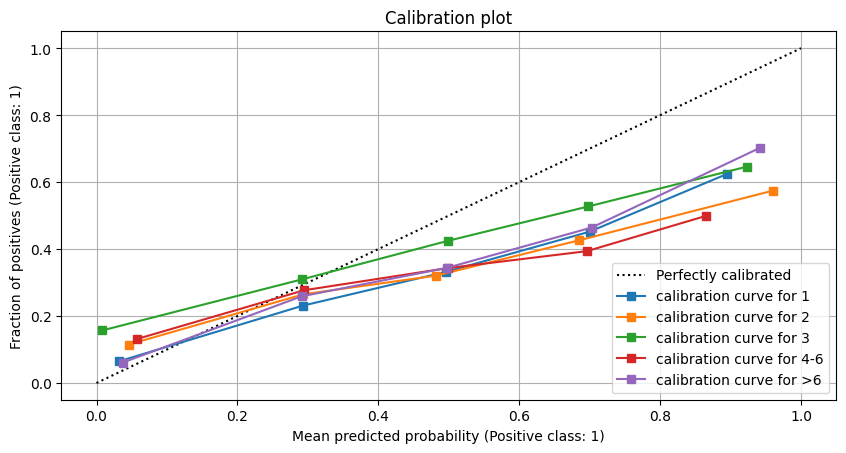

In [ ]:

with torch.no_grad():
    all_predictions = []
    actual_labels = []
    for X, Y in test_loader:
        X = X.to(device)
        Y = Y.to(device)
        output = model(X)
        all_predictions.append(output.cpu().numpy())
        actual_labels.append(Y.cpu().numpy())
    prediction_probs = np.concatenate(all_predictions, axis = 0)
    actual_labels = np.concatenate(actual_labels, axis = 0)
    labels = ["1", "2", "3", "4-6", ">6"]

    fig = plt.figure(figsize=(10, 10))
    gs = GridSpec(4, 2)
    colors = plt.get_cmap("Dark2")

    ax_calibration = fig.add_subplot(gs[:2, :2])
    for (idx, label) in enumerate(labels):
        CalibrationDisplay.from_predictions(np.where(actual_labels==idx, 1, 0), prediction_probs[:, idx], ax = ax_calibration, name = f"calibration curve for {label}")

    ax_calibration.grid()
    ax_calibration.set_title("Calibration plot")
    plt.show()


area under roc curve = 0.7511634679331175


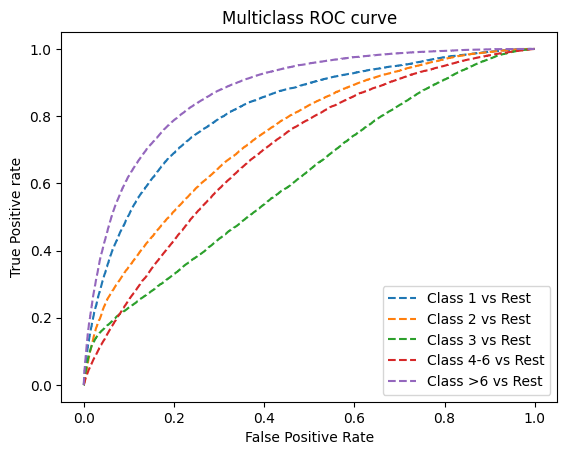

In [ ]:

def plot_roc_curves(prediction_prob, actual_y):
    fpr = {}
    tpr = {}
    thresh ={}

    classes = ["1", "2", "3", "4-6", ">6"]

    for i in range(N_CLASSES):
        fpr[i], tpr[i], thresh[i] = roc_curve(np.where(actual_y==i, 1, 0), prediction_prob[:,i])
        plt.plot(fpr[i], tpr[i], linestyle='--', label=f'Class {classes[i]} vs Rest')

    plt.title('Multiclass ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive rate')
    plt.legend(loc='best')
    plt.savefig('Multiclass ROC',dpi=300)
    area_under_roc_curve = roc_auc_score(actual_y, prediction_prob, multi_class="ovr")
    print(f"area under roc curve = {area_under_roc_curve}")

with torch.no_grad():
    all_predictions = []
    actual_labels = []
    for X, Y in test_loader:
        X = X.to(device)
        Y = Y.to(device)
        output = model(X)
        all_predictions.append(output.cpu().numpy())
        actual_labels.append(Y.cpu().numpy())
    prediction_probs = np.concatenate(all_predictions, axis = 0)
    actual_labels = np.concatenate(actual_labels, axis = 0)
    plot_roc_curves(prediction_probs, actual_labels)


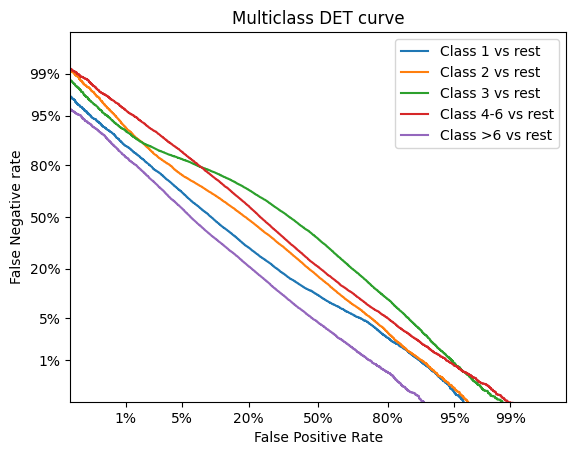

In [ ]:

def plot_det_curves(prediction_prob, actual_y):
    fpr = {}
    tpr = {}
    thresh ={}

    classes = ["1", "2", "3", "4-6", ">6"]
    fig, ax = plt.subplots()
    for i in range(N_CLASSES):
        DetCurveDisplay.from_predictions(np.where(actual_y==i, 1, 0), prediction_prob[:,i], ax = ax, name = f"Class {classes[i]} vs rest")


    plt.title('Multiclass DET curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('False Negative rate')
    plt.legend(loc='best')
    plt.savefig('Multiclass DET',dpi=300)
    plt.show()

with torch.no_grad():
    all_predictions = []
    actual_labels = []
    for X, Y in test_loader:
        X = X.to(device)
        Y = Y.to(device)
        output = model(X)
        all_predictions.append(output.cpu().numpy())
        actual_labels.append(Y.cpu().numpy())
    prediction_probs = np.concatenate(all_predictions, axis = 0)
    actual_labels = np.concatenate(actual_labels, axis = 0)
    plot_det_curves(prediction_probs, actual_labels)


### Cross Validation

In [ ]:
if DRY_RUN:
    n_splits = 2
    k_f = KFold(n_splits=n_splits)
else:
    n_splits = 10
    k_f = KFold(n_splits=n_splits)

total_score = 0
for fold, (train_ids, val_ids) in enumerate(k_f.split(train_dataset)):
    print(f'FOLD {fold}')
    print('--------------------------------')

    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)
    train_loader = DataLoader(
                      dataset,
                      batch_size=70, sampler=train_subsampler)
    val_loader = DataLoader(
                      dataset,
                      batch_size=70, sampler=val_subsampler)

    score, _ = train_and_evaluate(train_loader, val_loader, verbose = False, n_epochs=5)
    total_score += score

total_score/n_splits

FOLD 0
--------------------------------
At epoch 1 of 5 epochs
At epoch 2 of 5 epochs
At epoch 3 of 5 epochs
At epoch 4 of 5 epochs
At epoch 5 of 5 epochs
micro averaged metrics: (0.4490111653616812, 0.4490111653616812, 0.4490111653616812, None)
macro averaged metrics: (0.4650536188365223, 0.44870095501033475, 0.430088547433719, None)
weighted averaged metrics: (0.4619967335756187, 0.4490111653616812, 0.43002570460558337, None)
              precision    recall  f1-score   support

           0       0.42      0.52      0.47     30078
           1       0.45      0.39      0.42     40446
           2       0.55      0.16      0.25     35833
           3       0.37      0.45      0.41     45840
           4       0.52      0.72      0.61     38482

    accuracy                           0.45    190679
   macro avg       0.47      0.45      0.43    190679
weighted avg       0.46      0.45      0.43    190679

FOLD 1
--------------------------------
At epoch 1 of 5 epochs
At epoch 2 of 5 

0.46065553984366964

### Test on Unseen Dataset

In [ ]:
dataset_2017 = '/content/drive/MyDrive/data_2017.csv'
def map_columns_from_2016_to_2017(col):
    if col=="Hospital Service Area":
        return "Health Service Area"
    if col == "Permanent Facility Id":
        return "Facility Id"
    return col
unseen_dataset = HospitalDataset(dataset = dataset_2017, new_born = False, test = True, mappings = dataset.mappings, column_mapping = map_columns_from_2016_to_2017, d = dataset.d)
unseen_dataset_loader = DataLoader(dataset=unseen_dataset, batch_size=4200, shuffle=False)


In [ ]:
all_predictions = []
actual_labels = []
accurate_prediction_count = 0
total_sample_count = 0
with torch.no_grad():
    for x, y in unseen_dataset_loader:
        x = x.to(device)
        y = y.to(device)
        output = model(x)
        _, pred = output.max(1)
        total_sample_count = total_sample_count + y.size(0)
        accurate_prediction_count = accurate_prediction_count + pred.eq(y).sum().item()
print(f"{accurate_prediction_count} accurate predictions out of {total_sample_count} samples")
accuracy = accurate_prediction_count/total_sample_count
print(accuracy)

990400 accurate predictions out of 2123886 samples
0.4663150470411312


## Newborns

### Division into Train, Validation, Test Dataset

In [ ]:
dataset = HospitalDataset(new_born = True)
r = len(dataset)
train_size, val_size, test_size = int(r*0.9), int(r*0.05), r - int(r*0.05) - int(r*0.9)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))
print(f"{train_size} training samples, {val_size} validation samples, {test_size} test samples")
train_loader = DataLoader(dataset=train_dataset, batch_size=4200, shuffle=False)
val_loader = DataLoader(dataset=val_dataset, batch_size=4200, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=4200, shuffle=False)

202301 training samples, 11238 validation samples, 11240 test samples


### Running Logistic regresssion

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
class LR(nn.Module):
    def __init__(self):
        super(LR, self).__init__()
        self.fc1 = nn.Linear(1611,N_CLASSES)

    def forward(self, x):
        x = self.fc1(x)
        x = F.softmax(x, dim=1)
        return x

def train_and_evaluate(train_loader, test_loader, verbose = True, cross_validation = False, n_epochs = 10):
    model  = LR().to(device)
    criterion = nn.CrossEntropyLoss()
    criterion = criterion.to(device)
    optimizer = optim.Adam(model.parameters(),lr=1e-3,weight_decay=1e-4)
    lr = sch.StepLR(optimizer,step_size=5,gamma=0.1)

    i = 1
    while(i <= n_epochs):
        print(f"At epoch {i} of {n_epochs} epochs")
        model.train()
        epoch_loss = 0
        for X, Y in train_loader:
            X = X.to(device)
            Y = Y.to(device)

            output = model(X)

            loss = criterion(output,Y.long())
            optimizer.zero_grad()
            loss.backward()
            epoch_loss += loss.item()
            optimizer.step()

        accurate_prediction_count = 0
        total_sample_count = 0
        model.eval()

        with torch.no_grad():
            for X, Y in val_loader:
                X = X.to(device)
                Y = Y.to(device)
                output = model(X)
                _, pred = output.max(1)
                total_sample_count = total_sample_count + Y.size(0)
                accurate_prediction_count = accurate_prediction_count + pred.eq(Y).sum().item()
        if verbose:
            print(f"At the end of epoch {i}, {accurate_prediction_count} correct predictions, accuracy = {accurate_prediction_count/total_sample_count}, training loss = {epoch_loss}")

        i = i+1

    accurate_prediction_count = 0
    total_sample_count = 0
    model.eval()

    if cross_validation:
        with torch.no_grad():
            for X,Y in test_loader:
                X = X.to(device)
                Y = Y.to(device)
                output = model(X)
                _, pred = output.max(1)
                total_sample_count = total_sample_count + Y.size(0)
                accurate_prediction_count = accurate_prediction_count + pred.eq(Y).sum().item()
    else:
        with torch.no_grad():
            all_predictions = []
            actual_labels = []
            for X,Y in test_loader:
                X = X.to(device)
                Y = Y.to(device)
                output = model(X)
                _, pred = output.max(1)
                all_predictions.append(pred.cpu().numpy())
                actual_labels.append(Y.cpu().numpy())
                total_sample_count = total_sample_count + Y.size(0)
                accurate_prediction_count = accurate_prediction_count + pred.eq(Y).sum().item()
            all_predictions = np.concatenate(all_predictions, axis = 0)
            actual_labels = np.concatenate(actual_labels, axis = 0)
            macro_prfs_data = precision_recall_fscore_support(actual_labels, all_predictions, average = 'macro')
            weighted_prfs_data = precision_recall_fscore_support(actual_labels, all_predictions, average = 'weighted')
            micro_prfs_data = precision_recall_fscore_support(actual_labels, all_predictions, average = 'micro')
            print(f"micro averaged metrics: {micro_prfs_data}")
            print(f"macro averaged metrics: {macro_prfs_data}")
            print(f"weighted averaged metrics: {weighted_prfs_data}")
            report = classification_report(actual_labels, all_predictions)
            print(report)

    accuracy = accurate_prediction_count/total_sample_count

    if verbose:
        print(f"{accurate_prediction_count} accurate predictions out of {total_sample_count} samples")
        print(accuracy)

    return accuracy, model

if DRY_RUN:
    _, model = train_and_evaluate(train_loader, val_loader, n_epochs = 5)
else:
    _, model = train_and_evaluate(train_loader, val_loader, n_epochs = 10)



At epoch 1 of 10 epochs
At the end of epoch 1, 6096 correct predictions, accuracy = 0.5424452749599573, training loss = 74.7066240310669
At epoch 2 of 10 epochs
At the end of epoch 2, 6096 correct predictions, accuracy = 0.5424452749599573, training loss = 68.78033745288849
At epoch 3 of 10 epochs
At the end of epoch 3, 6096 correct predictions, accuracy = 0.5424452749599573, training loss = 67.37185311317444
At epoch 4 of 10 epochs
At the end of epoch 4, 6098 correct predictions, accuracy = 0.5426232425698523, training loss = 66.99520409107208
At epoch 5 of 10 epochs
At the end of epoch 5, 6113 correct predictions, accuracy = 0.5439579996440648, training loss = 66.77762949466705
At epoch 6 of 10 epochs
At the end of epoch 6, 6163 correct predictions, accuracy = 0.5484071898914398, training loss = 66.58125150203705
At epoch 7 of 10 epochs
At the end of epoch 7, 6223 correct predictions, accuracy = 0.5537462181882897, training loss = 66.36760783195496
At epoch 8 of 10 epochs
At the end 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

### Debrier Score

In [ ]:
# prompt: debrier score in python

def debrier_score(y_true, y_pred):
    """
    Computes the Debrier score, a measure of calibration for binary classifiers.

    Args:
        y_true (ndarray): Ground truth labels.
        y_pred (ndarray): Predicted probabilities.

    Returns:
        float: The Debrier score.
    """

    return np.mean((y_true.T - y_pred.T)**2)


with torch.no_grad():
    all_predictions = []
    actual_labels = []
    for X, Y in test_loader:
        X = X.to(device)
        Y = Y.to(device)
        output = model(X)
        all_predictions.append(output.cpu().numpy())
        actual_labels.append(Y.cpu().numpy())
    prediction_probs = np.concatenate(all_predictions, axis = 0)
    actual_labels = np.concatenate(actual_labels, axis = 0)
    debrier_score = debrier_score(actual_labels, prediction_probs)
    print(f"debrier_score is {debrier_score}")

debrier_score is 2.7815634151262576


### Plot metrics

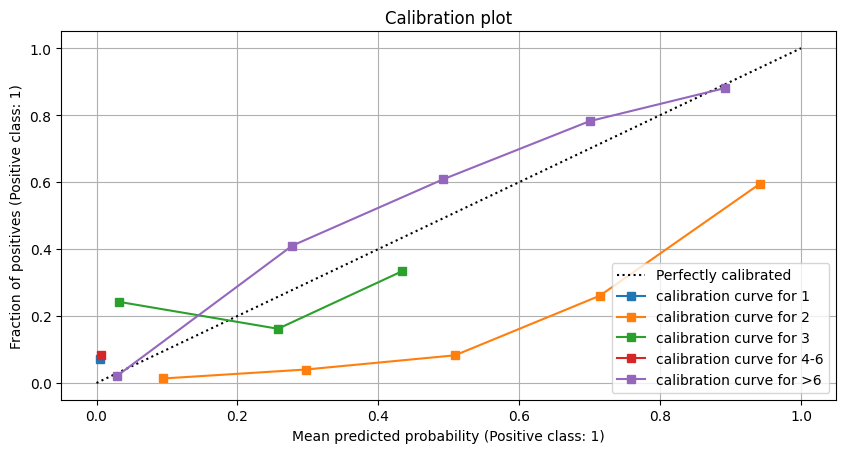

In [ ]:

with torch.no_grad():
    all_predictions = []
    actual_labels = []
    for X, Y in test_loader:
        X = X.to(device)
        Y = Y.to(device)
        output = model(X)
        all_predictions.append(output.cpu().numpy())
        actual_labels.append(Y.cpu().numpy())
    prediction_probs = np.concatenate(all_predictions, axis = 0)
    actual_labels = np.concatenate(actual_labels, axis = 0)
    labels = ["1", "2", "3", "4-6", ">6"]

    fig = plt.figure(figsize=(10, 10))
    gs = GridSpec(4, 2)
    colors = plt.get_cmap("Dark2")

    ax_calibration = fig.add_subplot(gs[:2, :2])
    for (idx, label) in enumerate(labels):
        CalibrationDisplay.from_predictions(np.where(actual_labels==idx, 1, 0), prediction_probs[:, idx], ax = ax_calibration, name = f"calibration curve for {label}")

    ax_calibration.grid()
    ax_calibration.set_title("Calibration plot")
    plt.show()


area under roc curve = 0.6837563173353306


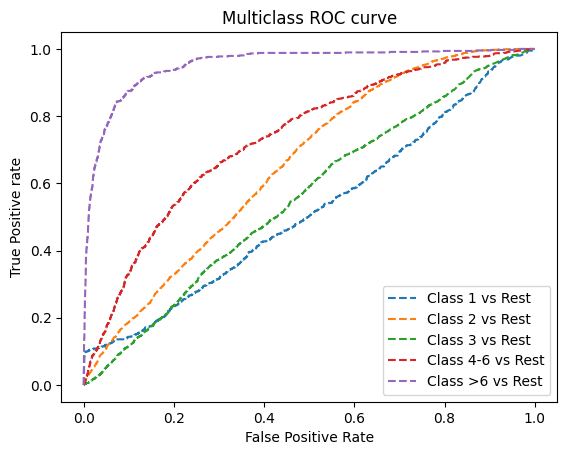

In [ ]:

def plot_roc_curves(prediction_prob, actual_y):
    fpr = {}
    tpr = {}
    thresh ={}

    classes = ["1", "2", "3", "4-6", ">6"]

    for i in range(N_CLASSES):
        fpr[i], tpr[i], thresh[i] = roc_curve(np.where(actual_y==i, 1, 0), prediction_prob[:,i])
        plt.plot(fpr[i], tpr[i], linestyle='--', label=f'Class {classes[i]} vs Rest')

    plt.title('Multiclass ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive rate')
    plt.legend(loc='best')
    plt.savefig('Multiclass ROC',dpi=300)
    area_under_roc_curve = roc_auc_score(actual_y, prediction_prob, multi_class="ovr")
    print(f"area under roc curve = {area_under_roc_curve}")

with torch.no_grad():
    all_predictions = []
    actual_labels = []
    for X, Y in test_loader:
        X = X.to(device)
        Y = Y.to(device)
        output = model(X)
        all_predictions.append(output.cpu().numpy())
        actual_labels.append(Y.cpu().numpy())
    prediction_probs = np.concatenate(all_predictions, axis = 0)
    actual_labels = np.concatenate(actual_labels, axis = 0)
    plot_roc_curves(prediction_probs, actual_labels)


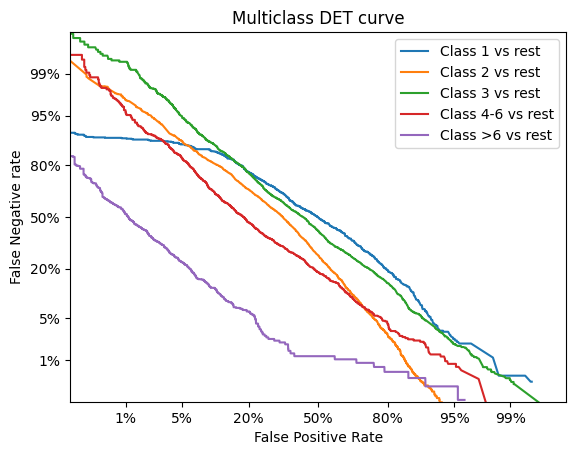

In [ ]:


def plot_det_curves(prediction_prob, actual_y):
    fpr = {}
    tpr = {}
    thresh ={}

    classes = ["1", "2", "3", "4-6", ">6"]
    fig, ax = plt.subplots()
    for i in range(N_CLASSES):
        DetCurveDisplay.from_predictions(np.where(actual_y==i, 1, 0), prediction_prob[:,i], ax = ax, name = f"Class {classes[i]} vs rest")


    plt.title('Multiclass DET curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('False Negative rate')
    plt.legend(loc='best')
    plt.savefig('Multiclass DET',dpi=300)
    plt.show()

with torch.no_grad():
    all_predictions = []
    actual_labels = []
    for X, Y in test_loader:
        X = X.to(device)
        Y = Y.to(device)
        output = model(X)
        all_predictions.append(output.cpu().numpy())
        actual_labels.append(Y.cpu().numpy())
    prediction_probs = np.concatenate(all_predictions, axis = 0)
    actual_labels = np.concatenate(actual_labels, axis = 0)
    plot_det_curves(prediction_probs, actual_labels)


### Cross Validation

In [ ]:
if DRY_RUN:
    n_splits = 2
    k_f = KFold(n_splits=n_splits)
else:
    n_splits = 10
    k_f = KFold(n_splits=n_splits)

total_score = 0
for fold, (train_ids, val_ids) in enumerate(k_f.split(train_dataset)):
    print(f'FOLD {fold}')
    print('--------------------------------')

    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)
    train_loader = DataLoader(
                      dataset,
                      batch_size=70, sampler=train_subsampler)
    val_loader = DataLoader(
                      dataset,
                      batch_size=70, sampler=val_subsampler)

    score, _ = train_and_evaluate(train_loader, val_loader, verbose = False, n_epochs=5)
    total_score += score

total_score/n_splits

FOLD 0
--------------------------------
At epoch 1 of 5 epochs
At epoch 2 of 5 epochs
At epoch 3 of 5 epochs
At epoch 4 of 5 epochs
At epoch 5 of 5 epochs


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

micro averaged metrics: (0.604072957342692, 0.604072957342692, 0.604072957342692, None)
macro averaged metrics: (0.4626167593389138, 0.3922699538949483, 0.35074813257482484, None)
weighted averaged metrics: (0.5149798996103008, 0.604072957342692, 0.48885253393214056, None)
              precision    recall  f1-score   support

           0       0.74      0.12      0.21      2200
           1       0.61      0.98      0.75     11051
           2       0.31      0.04      0.07      4168
           3       0.00      0.00      0.00      1586
           4       0.65      0.83      0.73      1226

    accuracy                           0.60     20231
   macro avg       0.46      0.39      0.35     20231
weighted avg       0.51      0.60      0.49     20231

FOLD 1
--------------------------------
At epoch 1 of 5 epochs
At epoch 2 of 5 epochs
At epoch 3 of 5 epochs
At epoch 4 of 5 epochs
At epoch 5 of 5 epochs


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

micro averaged metrics: (0.6150271873455264, 0.6150271873455264, 0.6150271873455264, None)
macro averaged metrics: (0.4996115222901502, 0.38800056901007884, 0.35925142682055505, None)
weighted averaged metrics: (0.559758007838602, 0.6150271873455264, 0.5064303758590235, None)
              precision    recall  f1-score   support

           0       0.82      0.09      0.17      2859
           1       0.61      0.98      0.75     11246
           2       0.31      0.06      0.10      3790
           3       0.00      0.00      0.00      1171
           4       0.74      0.81      0.78      1164

    accuracy                           0.62     20230
   macro avg       0.50      0.39      0.36     20230
weighted avg       0.56      0.62      0.51     20230

FOLD 2
--------------------------------
At epoch 1 of 5 epochs
At epoch 2 of 5 epochs
At epoch 3 of 5 epochs
At epoch 4 of 5 epochs
At epoch 5 of 5 epochs


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

micro averaged metrics: (0.5553633217993079, 0.5553633217993079, 0.5553633217993079, None)
macro averaged metrics: (0.30352624140648193, 0.36989666321167197, 0.3018624203356258, None)
weighted averaged metrics: (0.3896704892556306, 0.5553633217993079, 0.42104778246373237, None)
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2995
           1       0.56      0.98      0.71     10326
           2       0.33      0.05      0.09      4209
           3       0.00      0.00      0.00      1549
           4       0.63      0.82      0.71      1151

    accuracy                           0.56     20230
   macro avg       0.30      0.37      0.30     20230
weighted avg       0.39      0.56      0.42     20230

FOLD 3
--------------------------------
At epoch 1 of 5 epochs
At epoch 2 of 5 epochs
At epoch 3 of 5 epochs
At epoch 4 of 5 epochs
At epoch 5 of 5 epochs


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

micro averaged metrics: (0.6125061789421651, 0.6125061789421651, 0.6125061789421651, None)
macro averaged metrics: (0.46909901792997105, 0.4070541036324988, 0.3705016550269639, None)
weighted averaged metrics: (0.49955616069262687, 0.6125061789421651, 0.495994175103124, None)
              precision    recall  f1-score   support

           0       0.79      0.22      0.34      1006
           1       0.62      0.98      0.76     11487
           2       0.36      0.05      0.08      4782
           3       0.00      0.00      0.00      2142
           4       0.58      0.78      0.66       813

    accuracy                           0.61     20230
   macro avg       0.47      0.41      0.37     20230
weighted avg       0.50      0.61      0.50     20230

FOLD 4
--------------------------------
At epoch 1 of 5 epochs
At epoch 2 of 5 epochs
At epoch 3 of 5 epochs
At epoch 4 of 5 epochs
At epoch 5 of 5 epochs


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

micro averaged metrics: (0.5949085516559565, 0.5949085516559565, 0.5949085516559565, None)
macro averaged metrics: (0.481318952446801, 0.42032035766311626, 0.39173162931532507, None)
weighted averaged metrics: (0.49523123028766747, 0.5949085516559565, 0.49438398910990566, None)
              precision    recall  f1-score   support

           0       0.78      0.23      0.36       242
           1       0.61      0.95      0.74     10434
           2       0.40      0.09      0.15      5942
           3       0.00      0.00      0.00      1765
           4       0.63      0.83      0.71      1847

    accuracy                           0.59     20230
   macro avg       0.48      0.42      0.39     20230
weighted avg       0.50      0.59      0.49     20230

FOLD 5
--------------------------------
At epoch 1 of 5 epochs
At epoch 2 of 5 epochs
At epoch 3 of 5 epochs
At epoch 4 of 5 epochs
At epoch 5 of 5 epochs


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

micro averaged metrics: (0.6311913000494316, 0.6311913000494316, 0.6311913000494316, None)
macro averaged metrics: (0.47860224246257904, 0.3749297887876189, 0.3285371971556593, None)
weighted averaged metrics: (0.5397678383021725, 0.6311913000494316, 0.5244671619407612, None)
              precision    recall  f1-score   support

           0       0.79      0.04      0.08       741
           1       0.65      0.97      0.78     11958
           2       0.38      0.06      0.11      5292
           3       0.00      0.00      0.00      1228
           4       0.58      0.80      0.67      1011

    accuracy                           0.63     20230
   macro avg       0.48      0.37      0.33     20230
weighted avg       0.54      0.63      0.52     20230

FOLD 6
--------------------------------
At epoch 1 of 5 epochs
At epoch 2 of 5 epochs
At epoch 3 of 5 epochs
At epoch 4 of 5 epochs
At epoch 5 of 5 epochs


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

micro averaged metrics: (0.6087988136431043, 0.6087988136431043, 0.6087988136431043, None)
macro averaged metrics: (0.4820437724246843, 0.37732842038749903, 0.31950170074121986, None)
weighted averaged metrics: (0.5177787651696149, 0.6087988136431043, 0.4862816277021197, None)
              precision    recall  f1-score   support

           0       0.79      0.03      0.05      1111
           1       0.61      0.98      0.75     11396
           2       0.38      0.04      0.08      4957
           3       0.00      0.00      0.00      1660
           4       0.62      0.84      0.71      1106

    accuracy                           0.61     20230
   macro avg       0.48      0.38      0.32     20230
weighted avg       0.52      0.61      0.49     20230

FOLD 7
--------------------------------
At epoch 1 of 5 epochs
At epoch 2 of 5 epochs
At epoch 3 of 5 epochs
At epoch 4 of 5 epochs
At epoch 5 of 5 epochs


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

micro averaged metrics: (0.5761739990113692, 0.5761739990113692, 0.5761739990113692, None)
macro averaged metrics: (0.4680682371500888, 0.367562649917203, 0.3210537882450086, None)
weighted averaged metrics: (0.46995227384669674, 0.5761739990113692, 0.4549895491607703, None)
              precision    recall  f1-score   support

           0       0.75      0.01      0.02      1520
           1       0.58      0.97      0.72     10542
           2       0.28      0.06      0.10      4235
           3       0.00      0.00      0.00      2453
           4       0.73      0.80      0.76      1480

    accuracy                           0.58     20230
   macro avg       0.47      0.37      0.32     20230
weighted avg       0.47      0.58      0.45     20230

FOLD 8
--------------------------------
At epoch 1 of 5 epochs
At epoch 2 of 5 epochs
At epoch 3 of 5 epochs
At epoch 4 of 5 epochs
At epoch 5 of 5 epochs


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

micro averaged metrics: (0.5653979238754325, 0.5653979238754325, 0.5653979238754325, None)
macro averaged metrics: (0.4364162133307149, 0.36427395234586424, 0.3242927624003221, None)
weighted averaged metrics: (0.4670854156718644, 0.5653979238754325, 0.44345130841597663, None)
              precision    recall  f1-score   support

           0       0.61      0.08      0.14       562
           1       0.57      0.97      0.72     10701
           2       0.36      0.05      0.08      6513
           3       0.00      0.00      0.00      1440
           4       0.64      0.73      0.68      1014

    accuracy                           0.57     20230
   macro avg       0.44      0.36      0.32     20230
weighted avg       0.47      0.57      0.44     20230

FOLD 9
--------------------------------
At epoch 1 of 5 epochs
At epoch 2 of 5 epochs
At epoch 3 of 5 epochs
At epoch 4 of 5 epochs
At epoch 5 of 5 epochs
micro averaged metrics: (0.6085516559565003, 0.6085516559565003, 0.60855165595

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

0.5971991889621486

### Test on Unseen Dataset

In [ ]:
dataset_2017 = '/content/drive/MyDrive/data_2017.csv'
def map_columns_from_2016_to_2017(col):
    if col=="Hospital Service Area":
        return "Health Service Area"
    if col == "Permanent Facility Id":
        return "Facility Id"
    return col
unseen_dataset = HospitalDataset(dataset = dataset_2017, new_born = False, test = True, mappings = dataset.mappings, column_mapping = map_columns_from_2016_to_2017, d = dataset.d)
unseen_dataset_loader = DataLoader(dataset=unseen_dataset, batch_size=4200, shuffle=False)


In [ ]:
all_predictions = []
actual_labels = []
accurate_prediction_count = 0
total_sample_count = 0
with torch.no_grad():
    for x, y in unseen_dataset_loader:
        x = x.to(device)
        y = y.to(device)
        output = model(x)
        _, pred = output.max(1)
        total_sample_count = total_sample_count + y.size(0)
        accurate_prediction_count = accurate_prediction_count + pred.eq(y).sum().item()
print(f"{accurate_prediction_count} accurate predictions out of {total_sample_count} samples")
accuracy = accurate_prediction_count/total_sample_count
print(accuracy)

# Random Forest Classifer

### Imports

In [ ]:
import numpy as np
import pandas as pd
from IPython.display import display, HTML
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as sch
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from scipy import stats
from torch.utils.data import Dataset,DataLoader, random_split
import math
from sklearn.metrics import roc_curve, det_curve, DetCurveDisplay
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, classification_report
from sklearn.calibration import CalibrationDisplay, calibration_curve
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from collections import defaultdict

Set this to False if you want to run the following cells for the complete dataset.

In [ ]:
DRY_RUN = False

### Data Preprocessing

In [ ]:
def map_labels_five_class(x):
    if x==1:
        return 0
    if x==2:
        return 1
    if x==3:
        return 2
    if (x >= 4) and (x <= 6):
        return 3
    if (x >6):
        return 4

In [ ]:
def transform_data(df, new_born=False, label_mapping = None):
    df.drop(['CCS Diagnosis Description', 'CCS Procedure Description', 'APR DRG Description', 'APR MDC Description',
                    'APR Severity of Illness Description','Payment Typology 2','Payment Typology 3','Race','Gender','Birth Weight'], axis=1, inplace=True)
    if new_born:
        df.drop(df[df['Type of Admission'] != 'Newborn'].index, inplace=True)
    else:
        df.drop(df[df['Type of Admission'] == 'Newborn'].index, inplace=True)

    df['Length of Stay'] = df['Length of Stay'].replace('120 +',120)
    df['Length of Stay'] = df['Length of Stay'].astype(int)
    if label_mapping is not None:
        df['Length of Stay'] = df['Length of Stay'].map(label_mapping)

    list_of_unique_set_sizes = []
    columns_to_encode = ["Health Service Area", "Hospital County", "Operating Certificate Number", "Facility Id", "Facility Name", "Age Group", "Zip Code - 3 digits", "Ethnicity", "Type of Admission", "Patient Disposition", "CCS Diagnosis Code", "CCS Procedure Code", "APR DRG Code", "APR MDC Code", "APR Severity of Illness Code", "APR Risk of Mortality", "APR Medical Surgical Description", "Payment Typology 1", "Emergency Department Indicator"]
    index = 0
    mappings = {}
    for col in columns_to_encode:
        uniq_vals = df[col].unique()
        mapping = defaultdict(int)
        for v, k in enumerate(uniq_vals):
            mapping[k] = v
        mappings[col] = mapping

        df[col] = df[col].map(mapping)
        list_of_unique_set_sizes.append(len(uniq_vals))

    return df[columns_to_encode].values, df["Length of Stay"].values, list_of_unique_set_sizes, columns_to_encode, mappings

In [ ]:
def transform_test_data(df, one_hot_encoding, new_born=False, label_mapping = None):
    if new_born:
        df.drop(df[df['Type of Admission'] != 'Newborn'].index, inplace=True)
    else:
        df.drop(df[df['Type of Admission'] == 'Newborn'].index, inplace=True)

    df.drop(['CCS Diagnosis Description', 'CCS Procedure Description', 'APR DRG Description', 'APR MDC Description',
                    'APR Severity of Illness Description','Payment Typology 2','Payment Typology 3','Race','Gender','Birth Weight'], axis=1, inplace=True)
    df['Length of Stay'] = df['Length of Stay'].replace('120 +',120)
    df['Length of Stay'] = df['Length of Stay'].astype(int)
    if label_mapping is not None:
        df['Length of Stay'] = df['Length of Stay'].map(label_mapping)

    columns_to_encode = ["Health Service Area", "Hospital County", "Operating Certificate Number", "Facility Id", "Facility Name", "Age Group", "Zip Code - 3 digits", "Ethnicity", "Type of Admission", "Patient Disposition", "CCS Diagnosis Code", "CCS Procedure Code", "APR DRG Code", "APR MDC Code", "APR Severity of Illness Code", "APR Risk of Mortality", "APR Medical Surgical Description", "Payment Typology 1", "Emergency Department Indicator"]

    for col in columns_to_encode:
        df[col] = df[col].map(one_hot_encoding[col])

    return df[columns_to_encode].values, df["Length of Stay"].values, columns_to_encode,

### Defining the dataset class

The file path of the dataset in text format is to be specified in the below cell

In [ ]:
DATA_FILE_PATH = "/content/drive/MyDrive/data_2016.csv"
N_CLASSES = 5

class HospitalDataset(Dataset):
    def __init__(self, dataset = None, new_born = False, test = False, mappings = None, column_mapping = None, d = None):
        if DRY_RUN:
            if dataset is None:
                df = pd.read_csv(DATA_FILE_PATH, engine = 'python', nrows=100000) # The path here has to be replaced with the actual path
            else:
                df = pd.read_csv(dataset, engine = 'python', nrows=100000)
        else:
            if dataset is None:
                df = pd.read_csv(DATA_FILE_PATH, engine = 'python') # The path here has to be replaced with the actual path
            else:
                df = pd.read_csv(dataset, engine = 'python')

        if column_mapping is not None:
            df.columns = list(df.columns.map(column_mapping))

        if not test:
            self.X, self.Y, self.d, self.cols_to_oh_encode, self.mappings = transform_data(df, new_born, map_labels_five_class)
        else:
            self.X, self.Y, self.cols_to_oh_encode = transform_test_data(df, mappings, new_born, map_labels_five_class)
            self.d = d

    def __len__(self):
        return self.X.shape[0]

    def oh_encode(self, idx):
        x = self.X[idx]

        c = x.shape[0]
        X1 = np.zeros(1611)
        X1[-1] = 1
        index = 0
        for i, j in enumerate(self.d):
            X1[index + x[i]] = 1
            index += j

        return X1

    def __getitem__(self,idx):
        Y = self.Y[idx]
        X = self.oh_encode(idx)

        return torch.tensor(X, dtype=torch.float32), torch.tensor(Y)

## Non newborns

### Division into Train, Validation, Test Dataset

In [ ]:
dataset = HospitalDataset(new_born = False)
r = len(dataset)
train_size, val_size, test_size = int(r*0.9), int(r*0.05), r - int(r*0.05) - int(r*0.9)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))
print(f"{train_size} training samples, {val_size} validation samples, {test_size} test samples")
train_loader = DataLoader(dataset=train_dataset, batch_size=4200, shuffle=False)
val_loader = DataLoader(dataset=val_dataset, batch_size=4200, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=4200, shuffle=False)

1906785 training samples, 105932 validation samples, 105933 test samples


### Running Logistic regresssion

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
class LR(nn.Module):
    def __init__(self):
        super(LR, self).__init__()
        self.fc1 = nn.Linear(1611,N_CLASSES)

    def forward(self, x):
        x = self.fc1(x)
        x = F.softmax(x, dim=1)
        return x

def train_and_evaluate(train_loader, test_loader, verbose = True, cross_validation = False, n_epochs = 10):
    model  = LR().to(device)
    criterion = nn.CrossEntropyLoss()
    criterion = criterion.to(device)
    optimizer = optim.Adam(model.parameters(),lr=1e-3,weight_decay=1e-4)
    lr = sch.StepLR(optimizer,step_size=5,gamma=0.1)

    i = 1
    while(i <= n_epochs):
        print(f"At epoch {i} of {n_epochs} epochs")
        model.train()
        epoch_loss = 0
        for X, Y in train_loader:
            X = X.to(device)
            Y = Y.to(device)

            output = model(X)

            loss = criterion(output,Y.long())
            optimizer.zero_grad()
            loss.backward()
            epoch_loss += loss.item()
            optimizer.step()

        accurate_prediction_count = 0
        total_sample_count = 0
        model.eval()

        with torch.no_grad():
            for X, Y in val_loader:
                X = X.to(device)
                Y = Y.to(device)
                output = model(X)
                _, pred = output.max(1)
                total_sample_count = total_sample_count + Y.size(0)
                accurate_prediction_count = accurate_prediction_count + pred.eq(Y).sum().item()
        if verbose:
            print(f"At the end of epoch {i}, {accurate_prediction_count} correct predictions, accuracy = {accurate_prediction_count/total_sample_count}, training loss = {epoch_loss}")

        i = i+1

    accurate_prediction_count = 0
    total_sample_count = 0
    model.eval()

    if cross_validation:
        with torch.no_grad():
            for X,Y in test_loader:
                X = X.to(device)
                Y = Y.to(device)
                output = model(X)
                _, pred = output.max(1)
                total_sample_count = total_sample_count + Y.size(0)
                accurate_prediction_count = accurate_prediction_count + pred.eq(Y).sum().item()
    else:
        with torch.no_grad():
            all_predictions = []
            actual_labels = []
            for X,Y in test_loader:
                X = X.to(device)
                Y = Y.to(device)
                output = model(X)
                _, pred = output.max(1)
                all_predictions.append(pred.cpu().numpy())
                actual_labels.append(Y.cpu().numpy())
                total_sample_count = total_sample_count + Y.size(0)
                accurate_prediction_count = accurate_prediction_count + pred.eq(Y).sum().item()
            all_predictions = np.concatenate(all_predictions, axis = 0)
            actual_labels = np.concatenate(actual_labels, axis = 0)
            macro_prfs_data = precision_recall_fscore_support(actual_labels, all_predictions, average = 'macro')
            weighted_prfs_data = precision_recall_fscore_support(actual_labels, all_predictions, average = 'weighted')
            micro_prfs_data = precision_recall_fscore_support(actual_labels, all_predictions, average = 'micro')
            print(f"micro averaged metrics: {micro_prfs_data}")
            print(f"macro averaged metrics: {macro_prfs_data}")
            print(f"weighted averaged metrics: {weighted_prfs_data}")
            report = classification_report(actual_labels, all_predictions)
            print(report)

    accuracy = accurate_prediction_count/total_sample_count

    if verbose:
        print(f"{accurate_prediction_count} accurate predictions out of {total_sample_count} samples")
        print(accuracy)

    return accuracy, model

if DRY_RUN:
    _, model = train_and_evaluate(train_loader, val_loader, n_epochs = 5)
else:
    _, model = train_and_evaluate(train_loader, val_loader, n_epochs = 10)



At epoch 1 of 10 epochs
At the end of epoch 1, 47191 correct predictions, accuracy = 0.445483895329079, training loss = 684.9385814666748
At epoch 2 of 10 epochs
At the end of epoch 2, 48756 correct predictions, accuracy = 0.4602575236944455, training loss = 658.8540151119232
At epoch 3 of 10 epochs


### Debrier Score

In [ ]:
# prompt: debrier score in python

def debrier_score(y_true, y_pred):
    """
    Computes the Debrier score, a measure of calibration for binary classifiers.

    Args:
        y_true (ndarray): Ground truth labels.
        y_pred (ndarray): Predicted probabilities.

    Returns:
        float: The Debrier score.
    """

    return np.mean((y_true.T - y_pred.T)**2)


with torch.no_grad():
    all_predictions = []
    actual_labels = []
    for X, Y in test_loader:
        X = X.to(device)
        Y = Y.to(device)
        output = model(X)
        all_predictions.append(output.cpu().numpy())
        actual_labels.append(Y.cpu().numpy())
    prediction_probs = np.concatenate(all_predictions, axis = 0)
    actual_labels = np.concatenate(actual_labels, axis = 0)
    debrier_score = debrier_score(actual_labels, prediction_probs)
    print(f"debrier_score is {debrier_score}")

### Plot metrics

In [ ]:

with torch.no_grad():
    all_predictions = []
    actual_labels = []
    for X, Y in test_loader:
        X = X.to(device)
        Y = Y.to(device)
        output = model(X)
        all_predictions.append(output.cpu().numpy())
        actual_labels.append(Y.cpu().numpy())
    prediction_probs = np.concatenate(all_predictions, axis = 0)
    actual_labels = np.concatenate(actual_labels, axis = 0)
    labels = ["1", "2", "3", "4-6", ">6"]

    fig = plt.figure(figsize=(10, 10))
    gs = GridSpec(4, 2)
    colors = plt.get_cmap("Dark2")

    ax_calibration = fig.add_subplot(gs[:2, :2])
    for (idx, label) in enumerate(labels):
        CalibrationDisplay.from_predictions(np.where(actual_labels==idx, 1, 0), prediction_probs[:, idx], ax = ax_calibration, name = f"calibration curve for {label}")

    ax_calibration.grid()
    ax_calibration.set_title("Calibration plot")
    plt.show()


In [ ]:

def plot_roc_curves(prediction_prob, actual_y):
    fpr = {}
    tpr = {}
    thresh ={}

    classes = ["1", "2", "3", "4-6", ">6"]

    for i in range(N_CLASSES):
        fpr[i], tpr[i], thresh[i] = roc_curve(np.where(actual_y==i, 1, 0), prediction_prob[:,i])
        plt.plot(fpr[i], tpr[i], linestyle='--', label=f'Class {classes[i]} vs Rest')

    plt.title('Multiclass ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive rate')
    plt.legend(loc='best')
    plt.savefig('Multiclass ROC',dpi=300)
    area_under_roc_curve = roc_auc_score(actual_y, prediction_prob, multi_class="ovr")
    print(f"area under roc curve = {area_under_roc_curve}")

with torch.no_grad():
    all_predictions = []
    actual_labels = []
    for X, Y in test_loader:
        X = X.to(device)
        Y = Y.to(device)
        output = model(X)
        all_predictions.append(output.cpu().numpy())
        actual_labels.append(Y.cpu().numpy())
    prediction_probs = np.concatenate(all_predictions, axis = 0)
    actual_labels = np.concatenate(actual_labels, axis = 0)
    plot_roc_curves(prediction_probs, actual_labels)


In [ ]:

def plot_det_curves(prediction_prob, actual_y):
    fpr = {}
    tpr = {}
    thresh ={}

    classes = ["1", "2", "3", "4-6", ">6"]
    fig, ax = plt.subplots()
    for i in range(N_CLASSES):
        DetCurveDisplay.from_predictions(np.where(actual_y==i, 1, 0), prediction_prob[:,i], ax = ax, name = f"Class {classes[i]} vs rest")


    plt.title('Multiclass DET curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('False Negative rate')
    plt.legend(loc='best')
    plt.savefig('Multiclass DET',dpi=300)
    plt.show()

with torch.no_grad():
    all_predictions = []
    actual_labels = []
    for X, Y in test_loader:
        X = X.to(device)
        Y = Y.to(device)
        output = model(X)
        all_predictions.append(output.cpu().numpy())
        actual_labels.append(Y.cpu().numpy())
    prediction_probs = np.concatenate(all_predictions, axis = 0)
    actual_labels = np.concatenate(actual_labels, axis = 0)
    plot_det_curves(prediction_probs, actual_labels)


### Cross Validation

In [ ]:
if DRY_RUN:
    n_splits = 2
    k_f = KFold(n_splits=n_splits)
else:
    n_splits = 10
    k_f = KFold(n_splits=n_splits)

total_score = 0
for fold, (train_ids, val_ids) in enumerate(k_f.split(train_dataset)):
    print(f'FOLD {fold}')
    print('--------------------------------')

    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)
    train_loader = DataLoader(
                      dataset,
                      batch_size=70, sampler=train_subsampler)
    val_loader = DataLoader(
                      dataset,
                      batch_size=70, sampler=val_subsampler)

    score, _ = train_and_evaluate(train_loader, val_loader, verbose = False, n_epochs=5)
    total_score += score

total_score/n_splits

### Test on Unseen Dataset

In [ ]:
dataset_2017 = '/content/drive/MyDrive/data_2017.csv'
def map_columns_from_2016_to_2017(col):
    if col=="Hospital Service Area":
        return "Health Service Area"
    if col == "Permanent Facility Id":
        return "Facility Id"
    return col
unseen_dataset = HospitalDataset(dataset = dataset_2017, new_born = False, test = True, mappings = dataset.mappings, column_mapping = map_columns_from_2016_to_2017, d = dataset.d)
unseen_dataset_loader = DataLoader(dataset=unseen_dataset, batch_size=4200, shuffle=False)


In [ ]:
all_predictions = []
actual_labels = []
accurate_prediction_count = 0
total_sample_count = 0
with torch.no_grad():
    for x, y in unseen_dataset_loader:
        x = x.to(device)
        y = y.to(device)
        output = model(x)
        _, pred = output.max(1)
        total_sample_count = total_sample_count + y.size(0)
        accurate_prediction_count = accurate_prediction_count + pred.eq(y).sum().item()
print(f"{accurate_prediction_count} accurate predictions out of {total_sample_count} samples")
accuracy = accurate_prediction_count/total_sample_count
print(accuracy)

## Newborns

### Division into Train, Validation, Test Dataset

In [ ]:
dataset = HospitalDataset(new_born = True)
r = len(dataset)
train_size, val_size, test_size = int(r*0.9), int(r*0.05), r - int(r*0.05) - int(r*0.9)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))
print(f"{train_size} training samples, {val_size} validation samples, {test_size} test samples")
train_loader = DataLoader(dataset=train_dataset, batch_size=4200, shuffle=False)
val_loader = DataLoader(dataset=val_dataset, batch_size=4200, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=4200, shuffle=False)

### Running Logistic regresssion

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
class LR(nn.Module):
    def __init__(self):
        super(LR, self).__init__()
        self.fc1 = nn.Linear(1611,N_CLASSES)

    def forward(self, x):
        x = self.fc1(x)
        x = F.softmax(x, dim=1)
        return x

def train_and_evaluate(train_loader, test_loader, verbose = True, cross_validation = False, n_epochs = 10):
    model  = LR().to(device)
    criterion = nn.CrossEntropyLoss()
    criterion = criterion.to(device)
    optimizer = optim.Adam(model.parameters(),lr=1e-3,weight_decay=1e-4)
    lr = sch.StepLR(optimizer,step_size=5,gamma=0.1)

    i = 1
    while(i <= n_epochs):
        print(f"At epoch {i} of {n_epochs} epochs")
        model.train()
        epoch_loss = 0
        for X, Y in train_loader:
            X = X.to(device)
            Y = Y.to(device)

            output = model(X)

            loss = criterion(output,Y.long())
            optimizer.zero_grad()
            loss.backward()
            epoch_loss += loss.item()
            optimizer.step()

        accurate_prediction_count = 0
        total_sample_count = 0
        model.eval()

        with torch.no_grad():
            for X, Y in val_loader:
                X = X.to(device)
                Y = Y.to(device)
                output = model(X)
                _, pred = output.max(1)
                total_sample_count = total_sample_count + Y.size(0)
                accurate_prediction_count = accurate_prediction_count + pred.eq(Y).sum().item()
        if verbose:
            print(f"At the end of epoch {i}, {accurate_prediction_count} correct predictions, accuracy = {accurate_prediction_count/total_sample_count}, training loss = {epoch_loss}")

        i = i+1

    accurate_prediction_count = 0
    total_sample_count = 0
    model.eval()

    if cross_validation:
        with torch.no_grad():
            for X,Y in test_loader:
                X = X.to(device)
                Y = Y.to(device)
                output = model(X)
                _, pred = output.max(1)
                total_sample_count = total_sample_count + Y.size(0)
                accurate_prediction_count = accurate_prediction_count + pred.eq(Y).sum().item()
    else:
        with torch.no_grad():
            all_predictions = []
            actual_labels = []
            for X,Y in test_loader:
                X = X.to(device)
                Y = Y.to(device)
                output = model(X)
                _, pred = output.max(1)
                all_predictions.append(pred.cpu().numpy())
                actual_labels.append(Y.cpu().numpy())
                total_sample_count = total_sample_count + Y.size(0)
                accurate_prediction_count = accurate_prediction_count + pred.eq(Y).sum().item()
            all_predictions = np.concatenate(all_predictions, axis = 0)
            actual_labels = np.concatenate(actual_labels, axis = 0)
            macro_prfs_data = precision_recall_fscore_support(actual_labels, all_predictions, average = 'macro')
            weighted_prfs_data = precision_recall_fscore_support(actual_labels, all_predictions, average = 'weighted')
            micro_prfs_data = precision_recall_fscore_support(actual_labels, all_predictions, average = 'micro')
            print(f"micro averaged metrics: {micro_prfs_data}")
            print(f"macro averaged metrics: {macro_prfs_data}")
            print(f"weighted averaged metrics: {weighted_prfs_data}")
            report = classification_report(actual_labels, all_predictions)
            print(report)

    accuracy = accurate_prediction_count/total_sample_count

    if verbose:
        print(f"{accurate_prediction_count} accurate predictions out of {total_sample_count} samples")
        print(accuracy)

    return accuracy, model

if DRY_RUN:
    _, model = train_and_evaluate(train_loader, val_loader, n_epochs = 5)
else:
    _, model = train_and_evaluate(train_loader, val_loader, n_epochs = 10)



### Debrier Score

In [ ]:
# prompt: debrier score in python

def debrier_score(y_true, y_pred):
    """
    Computes the Debrier score, a measure of calibration for binary classifiers.

    Args:
        y_true (ndarray): Ground truth labels.
        y_pred (ndarray): Predicted probabilities.

    Returns:
        float: The Debrier score.
    """

    return np.mean((y_true.T - y_pred.T)**2)


with torch.no_grad():
    all_predictions = []
    actual_labels = []
    for X, Y in test_loader:
        X = X.to(device)
        Y = Y.to(device)
        output = model(X)
        all_predictions.append(output.cpu().numpy())
        actual_labels.append(Y.cpu().numpy())
    prediction_probs = np.concatenate(all_predictions, axis = 0)
    actual_labels = np.concatenate(actual_labels, axis = 0)
    debrier_score = debrier_score(actual_labels, prediction_probs)
    print(f"debrier_score is {debrier_score}")

### Plot metrics

In [ ]:

with torch.no_grad():
    all_predictions = []
    actual_labels = []
    for X, Y in test_loader:
        X = X.to(device)
        Y = Y.to(device)
        output = model(X)
        all_predictions.append(output.cpu().numpy())
        actual_labels.append(Y.cpu().numpy())
    prediction_probs = np.concatenate(all_predictions, axis = 0)
    actual_labels = np.concatenate(actual_labels, axis = 0)
    labels = ["1", "2", "3", "4-6", ">6"]

    fig = plt.figure(figsize=(10, 10))
    gs = GridSpec(4, 2)
    colors = plt.get_cmap("Dark2")

    ax_calibration = fig.add_subplot(gs[:2, :2])
    for (idx, label) in enumerate(labels):
        CalibrationDisplay.from_predictions(np.where(actual_labels==idx, 1, 0), prediction_probs[:, idx], ax = ax_calibration, name = f"calibration curve for {label}")

    ax_calibration.grid()
    ax_calibration.set_title("Calibration plot")
    plt.show()


In [ ]:

def plot_roc_curves(prediction_prob, actual_y):
    fpr = {}
    tpr = {}
    thresh ={}

    classes = ["1", "2", "3", "4-6", ">6"]

    for i in range(N_CLASSES):
        fpr[i], tpr[i], thresh[i] = roc_curve(np.where(actual_y==i, 1, 0), prediction_prob[:,i])
        plt.plot(fpr[i], tpr[i], linestyle='--', label=f'Class {classes[i]} vs Rest')

    plt.title('Multiclass ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive rate')
    plt.legend(loc='best')
    plt.savefig('Multiclass ROC',dpi=300)
    area_under_roc_curve = roc_auc_score(actual_y, prediction_prob, multi_class="ovr")
    print(f"area under roc curve = {area_under_roc_curve}")

with torch.no_grad():
    all_predictions = []
    actual_labels = []
    for X, Y in test_loader:
        X = X.to(device)
        Y = Y.to(device)
        output = model(X)
        all_predictions.append(output.cpu().numpy())
        actual_labels.append(Y.cpu().numpy())
    prediction_probs = np.concatenate(all_predictions, axis = 0)
    actual_labels = np.concatenate(actual_labels, axis = 0)
    plot_roc_curves(prediction_probs, actual_labels)


In [ ]:


def plot_det_curves(prediction_prob, actual_y):
    fpr = {}
    tpr = {}
    thresh ={}

    classes = ["1", "2", "3", "4-6", ">6"]
    fig, ax = plt.subplots()
    for i in range(N_CLASSES):
        DetCurveDisplay.from_predictions(np.where(actual_y==i, 1, 0), prediction_prob[:,i], ax = ax, name = f"Class {classes[i]} vs rest")


    plt.title('Multiclass DET curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('False Negative rate')
    plt.legend(loc='best')
    plt.savefig('Multiclass DET',dpi=300)
    plt.show()

with torch.no_grad():
    all_predictions = []
    actual_labels = []
    for X, Y in test_loader:
        X = X.to(device)
        Y = Y.to(device)
        output = model(X)
        all_predictions.append(output.cpu().numpy())
        actual_labels.append(Y.cpu().numpy())
    prediction_probs = np.concatenate(all_predictions, axis = 0)
    actual_labels = np.concatenate(actual_labels, axis = 0)
    plot_det_curves(prediction_probs, actual_labels)


### Cross Validation

In [ ]:
if DRY_RUN:
    n_splits = 2
    k_f = KFold(n_splits=n_splits)
else:
    n_splits = 10
    k_f = KFold(n_splits=n_splits)

total_score = 0
for fold, (train_ids, val_ids) in enumerate(k_f.split(train_dataset)):
    print(f'FOLD {fold}')
    print('--------------------------------')

    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)
    train_loader = DataLoader(
                      dataset,
                      batch_size=70, sampler=train_subsampler)
    val_loader = DataLoader(
                      dataset,
                      batch_size=70, sampler=val_subsampler)

    score, _ = train_and_evaluate(train_loader, val_loader, verbose = False, n_epochs=5)
    total_score += score

total_score/n_splits

### Test on Unseen Dataset

In [ ]:
dataset_2017 = '/content/drive/MyDrive/data_2017.csv'
def map_columns_from_2016_to_2017(col):
    if col=="Hospital Service Area":
        return "Health Service Area"
    if col == "Permanent Facility Id":
        return "Facility Id"
    return col
unseen_dataset = HospitalDataset(dataset = dataset_2017, new_born = False, test = True, mappings = dataset.mappings, column_mapping = map_columns_from_2016_to_2017, d = dataset.d)
unseen_dataset_loader = DataLoader(dataset=unseen_dataset, batch_size=4200, shuffle=False)


In [ ]:
all_predictions = []
actual_labels = []
accurate_prediction_count = 0
total_sample_count = 0
with torch.no_grad():
    for x, y in unseen_dataset_loader:
        x = x.to(device)
        y = y.to(device)
        output = model(x)
        _, pred = output.max(1)
        total_sample_count = total_sample_count + y.size(0)
        accurate_prediction_count = accurate_prediction_count + pred.eq(y).sum().item()
print(f"{accurate_prediction_count} accurate predictions out of {total_sample_count} samples")
accuracy = accurate_prediction_count/total_sample_count
print(accuracy)

# Minimal Feature Sets

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


import torch.optim.lr_scheduler as sch
from torch.utils.data import Dataset,DataLoader, random_split
import math

def transform_data(df, cols_to_oh_encode):
    index = 0
    arr = []
    total_oh_size = 0
    for col in cols_to_oh_encode:
        uniq_vals = df[col].unique()
        mapping = {k: v for v, k in enumerate(uniq_vals)}
        df[col] = df[col].map(mapping)
        arr.append(len(uniq_vals))
        total_oh_size += len(uniq_vals)
    return df[cols_to_oh_encode].values, df["LengthofStay"].values, arr, total_oh_size

class HospitalDataset(Dataset):
    def __init__(self, df, cols_to_oh_encode):
        self.X, self.Y, self.d, self.total_oh_size = transform_data(df, cols_to_oh_encode)
        self.cols_to_oh_encode = cols_to_oh_encode

    def __len__(self):
        return self.X.shape[0]

    def oh_encode(self, idx):
        x = self.X[idx]
        c = x.shape[0]
        X = np.zeros(self.total_oh_size)

        index = 0
        for i, j in enumerate(self.d):
            X[index + x[i]] = 1
            index += j


        return X
    def __getitem__(self, idx):
        Y = self.Y[idx]
        X = self.oh_encode(idx)

        return torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32)

df = pd.read_csv(DATA_FILE_PATH)

df = clean_data(df)



device = 'cuda' if torch.cuda.is_available() else 'cpu'

def train_and_evaluate(train_loader, val_loader, test_loader, no_of_features, epochs=4):
    model  = nn.Linear(no_of_features, 1).to(device)
    crit = nn.MSELoss()
    crit = crit.to(device)
    opti = optim.Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
    lr = sch.StepLR(opti,step_size=5,gamma=0.1)


    i = 1

    model.eval()
    x_squared_sum = 0
    x_sum = 0
    o_x_sum = 0
    x_mean = 0
    o_squared_sum = 0
    for x, y in val_loader:

        with torch.no_grad():
            y = y.to(device)
            x = x.to(device)
            o = model(x)
            o = o.squeeze(-1)
            x_squared_sum += torch.sum(y**2)
            x_sum += torch.sum(y)
            o_x_sum += torch.sum (torch.dot(o, y))
            o_squared_sum += torch.sum(o**2)
            target_sum = torch.sum(y)
    x_mean = x_sum / val_size
    r2_score_numerator = x_squared_sum + o_squared_sum - 2 * o_x_sum
    r2_score_denominator = x_squared_sum + val_size * (x_mean**2) - 2 * (x_sum) * x_mean


    print(f"Before the start of epoch 1, r2 score = {1 - r2_score_numerator/r2_score_denominator}")

    while(i <= epochs):
        print(f"At epoch {i} of {epochs} epochs")
        model.train()
        epoch_loss = 0
        for X, Y in train_loader:
            X = X.to(device)
            Y = Y.to(device)


            output = model(X)

            loss = crit(torch.squeeze(output),Y.float())
            opti.zero_grad()
            loss.backward()
            epoch_loss += loss.item()
            opti.step()

        model.eval()
        x_squared_sum = 0
        x_sum = 0
        o_x_sum = 0
        x_mean = 0
        o_squared_sum = 0
        for x, y in val_loader:

          with torch.no_grad():
            y = y.to(device)
            x = x.to(device)
            o = model(x)
            o = o.squeeze(-1)
            x_squared_sum += torch.sum(y**2)
            x_sum += torch.sum(y)
            o_x_sum += torch.sum (torch.dot(o, y))
            o_squared_sum += torch.sum(o**2)
            target_sum = torch.sum(y)
          x_mean = x_sum / val_size
          r2_score_numerator = x_squared_sum + o_squared_sum - 2 * o_x_sum
          r2_score_denominator = x_squared_sum + val_size * (x_mean**2) - 2 * (x_sum) * x_mean


        print(f"At the end of epoch {i}, r2 score = {1 - r2_score_numerator/r2_score_denominator}, training loss = {epoch_loss}")

        i = i+1

    model.eval()
    x_squared_sum = 0
    x_sum = 0
    o_x_sum = 0
    x_mean = 0
    o_squared_sum = 0
    for x, y in test_loader:

      with torch.no_grad():
        y = y.to(device)
        x = x.to(device)
        o = model(x)
        o = o.squeeze(-1)
        x_squared_sum += torch.sum(y**2)
        x_sum += torch.sum(y)
        o_x_sum += torch.sum (torch.dot(o, y))
        o_squared_sum += torch.sum(o**2)
        target_sum = torch.sum(y)
      x_mean = x_sum / val_size
      r2_score_numerator = x_squared_sum + o_squared_sum - 2 * o_x_sum
      r2_score_denominator = x_squared_sum + val_size * (x_mean**2) - 2 * (x_sum) * x_mean


    print(f"Test r2 score = {1 - r2_score_numerator/r2_score_denominator}")







dataset = HospitalDataset(df, ['APRSeverityofIllnessCode'])
r = len(dataset)
train_size, val_size, test_size = int(r*0.9), int(r*0.05), r - int(r*0.05) - int(r*0.9)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))
print(f"{train_size} training samples, {val_size} validation samples, {test_size} test samples")
train_loader = DataLoader(dataset=train_dataset, batch_size=70, shuffle=False)
val_loader = DataLoader(dataset=val_dataset, batch_size=70, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=70, shuffle=False)

train_and_evaluate(train_loader, val_loader, test_loader, dataset.total_oh_size)

def main(columns):
    dataset = HospitalDataset(df, columns)
    r = len(dataset)
    train_size, val_size, test_size = int(r*0.9), int(r*0.05), r - int(r*0.05) - int(r*0.9)
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))
    print(f"When columns {columns} are taken,")
    train_loader = DataLoader(dataset=train_dataset, batch_size=70, shuffle=False)
    val_loader = DataLoader(dataset=val_dataset, batch_size=70, shuffle=False)
    test_loader = DataLoader(dataset=test_dataset, batch_size=70, shuffle=False)
    train_and_evaluate(train_loader, val_loader, test_loader, dataset.total_oh_size)

column_arrays = [
                 ['APRSeverityofIllnessCode'],
                 ['APRDRGCode'],
                 ['APRSeverityofIllnessCode', 'APRDRGCode'],
                 ['APRMDCCode', 'APRDRGCode'],
                 ['APRMDCCode', 'APRSeverityofIllnessCode'],
                 ['APRMDCCode', 'APRSeverityofIllnessCode', 'APRDRGCode'],
                 ['APRMDCCode', 'APRSeverityofIllnessCode', 'APRDRGCode', 'PatientDisposition'],
                 ['APRMDCCode', 'APRSeverityofIllnessCode', 'APRDRGCode', 'PatientDisposition', 'CCSProcedureCode'],
                 ['APRMDCCode', 'APRSeverityofIllnessCode', 'APRDRGCode', 'PatientDisposition', 'CCSProcedureCode', 'CCSDiagnosisCode'],
                 ['APRMDCCode', 'APRSeverityofIllnessCode', 'APRDRGCode', 'PatientDisposition', 'CCSProcedureCode', 'CCSDiagnosisCode', 'TypeofAdmission'],
                 ['APRMDCCode', 'APRSeverityofIllnessCode', 'APRDRGCode', 'PatientDisposition', 'TypeofAdmission'],
                 ['APRMDCCode', 'APRSeverityofIllnessCode', 'APRDRGCode', 'PatientDisposition', 'APRMedicalSurgicalDescription'],
                 ['APRMDCCode', 'APRSeverityofIllnessCode', 'APRDRGCode', 'PatientDisposition', 'APRMedicalSurgicalDescription', 'TypeofAdmission'],
                 ['APRMDCCode', 'APRSeverityofIllnessCode', 'APRDRGCode', 'PatientDisposition',  'FacilityName'],
]

for column_array in column_arrays:
    main(column_array)


# Linear Regression

### Imports

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.model_selection import KFold
import torch.optim.lr_scheduler as sch
from torch.utils.data import Dataset, DataLoader, random_split
import math

### Data preprocessing

In [ ]:
def clean_data(df):
    df = df.dropna(subset=['Health Service Area','Hospital County','Operating Certificate Number',
                      'Facility Id','Zip Code - 3 digits',
                      'APR Severity of Illness Description','APR Risk of Mortality'])
    df.drop(df[df["Type of Admission"]==3].index, axis = 0, inplace=True)
    df.drop(['CCS Diagnosis Description', 'CCS Procedure Description', 'APR DRG Description', 'APR MDC Description', 'Total Costs', 'Total Charges', 'Discharge Year','Abortion Edit Indicator',
                  'APR Severity of Illness Description','Payment Typology 2','Payment Typology 3','Race','Gender','Birth Weight'], axis=1, inplace=True)

    df.loc[:, 'Length of Stay'] = df['Length of Stay'].replace('120 +',120)
    df.loc[:, 'Length of Stay'] = df['Length of Stay'].astype(np.int)

    df = df.sample(frac=1)

    names = df.columns
    n = len(names)
    i = 0
    names1 = []
    def remove(string):
      return string.replace(" ", "")
    while(i < n):
        s = remove(names[i])
        if(s == "ZipCode-3digits"):
            s = "ZipCodedigits"
        names1.append(s)
        i = i+1

    df.columns = names1

    return df

### Numerically encoding the data

In [ ]:
def transform_data(df):

  cols_to_oh_encode = ["HealthServiceArea", "HospitalCounty", "OperatingCertificateNumber", "FacilityId", "FacilityName", "AgeGroup", "ZipCodedigits", "Ethnicity", "TypeofAdmission", "PatientDisposition", "CCSDiagnosisCode", "CCSProcedureCode", "APRDRGCode", "APRMDCCode", "APRSeverityofIllnessCode", "APRRiskofMortality", "APRMedicalSurgicalDescription", "PaymentTypology1", "EmergencyDepartmentIndicator"]

  index = 0
  arr = []
  for col in cols_to_oh_encode:
    uniq_vals = df[col].unique()
    mapping = {k: v for v, k in enumerate(uniq_vals)}
    df[col] = df[col].map(mapping)
    arr.append(len(uniq_vals))
  return df[cols_to_oh_encode].values, df["LengthofStay"].values, arr, cols_to_oh_encode,

### Defining the hospital dataset

In [ ]:
class HospitalDataset(Dataset):
    def __init__(self, df, ):
        df = clean_data(df)
        self.X, self.Y, self.d, self.cols_to_oh_encode = transform_data(df)

    def __len__(self):
        return self.X.shape[0]

    def oh_encode(self, idx):
        x = self.X[idx]

        X = np.zeros(1610)

        index = 0
        for i, j in enumerate(self.d):
            X[index + x[i]] = 1
            index += j


        return X
    def __getitem__(self, idx):
        Y = self.Y[idx]
        X = self.oh_encode(idx)

        return torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32)

### Putting dataset into memory

The path of the dataset file is in the cell below

In [ ]:
DATA_FILE_PATH = '/content/Hospital_Inpatient_Discharges__SPARCS_De-Identified___2019.csv'
df = pd.read_csv(DATA_FILE_PATH)
dataset = HospitalDataset(df, )
r = len(dataset)
train_val_size, test_size = int(r*0.90), r - int(r*0.10)
train_val_dataset, test_dataset = random_split(dataset, [train_val_size, test_size], generator=torch.Generator().manual_seed(42))

print(f"{train_val_size} training and validation samples, {test_size} test samples")
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Function for training and evaluating

In [ ]:
def train_and_evaluate(train_loader, val_loader, n_epochs=5):
    model  = nn.Linear(1610, 1).to(device)
    crit = nn.MSELoss()
    crit = crit.to(device)
    opti = optim.Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
    lr = sch.StepLR(opti,step_size=5,gamma=0.1)
    val_size = 0

    i = 1

    model.eval()
    x_squared_sum = 0
    x_sum = 0
    o_x_sum = 0
    x_mean = 0
    o_squared_sum = 0
    for x, y in val_loader:
        val_size += x.shape[0]
        with torch.no_grad():
            y = y.to(device)
            x = x.to(device)
            o = model(x)
            o = o.squeeze(-1)
            x_squared_sum += torch.sum(y**2)
            x_sum += torch.sum(y)
            o_x_sum += torch.sum (torch.dot(o, y))
            o_squared_sum += torch.sum(o**2)
            target_sum = torch.sum(y)
    x_mean = x_sum / val_size
    r2_score_numerator = x_squared_sum + o_squared_sum - 2 * o_x_sum
    r2_score_denominator = x_squared_sum + val_size * (x_mean**2) - 2 * (x_sum) * x_mean


    print(f"Before the start of epoch 1, r2 score = {1 - r2_score_numerator/r2_score_denominator}")

    while(i <= n_epochs):
        print(f"At epoch {i} of {n_epochs} epochs")
        model.train()
        epoch_loss = 0
        for X, Y in train_loader:
            X = X.to(device)
            Y = Y.to(device)


            output = model(X)

            loss = crit(torch.squeeze(output),Y.float())
            opti.zero_grad()
            loss.backward()
            epoch_loss += loss.item()
            opti.step()

        model.eval()
        x_squared_sum = 0
        x_sum = 0
        o_x_sum = 0
        x_mean = 0
        o_squared_sum = 0
        for x, y in val_loader:

          with torch.no_grad():
            y = y.to(device)
            x = x.to(device)
            o = model(x)
            o = o.squeeze(-1)
            x_squared_sum += torch.sum(y**2)
            x_sum += torch.sum(y)
            o_x_sum += torch.sum (torch.dot(o, y))
            o_squared_sum += torch.sum(o**2)
            target_sum = torch.sum(y)
          x_mean = x_sum / val_size
          r2_score_numerator = x_squared_sum + o_squared_sum - 2 * o_x_sum
          r2_score_denominator = x_squared_sum + val_size * (x_mean**2) - 2 * (x_sum) * x_mean


        print(f"At the end of epoch {i}, r2 score = {1 - r2_score_numerator/r2_score_denominator}, training loss = {epoch_loss}")

        i = i+1



In [ ]:
len(train_val_dataset)

### Doing cross validation

In [ ]:
k_f = KFold(n_splits=10)
for fold, (train_ids, val_ids) in enumerate(k_f.split(train_val_dataset)):
    # Print
    print(f'FOLD {fold}')
    print('--------------------------------')

    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)
    train_loader = DataLoader(
                      dataset,
                      batch_size=70, sampler=train_subsampler)
    val_loader = DataLoader(
                      dataset,
                      batch_size=70, sampler=val_subsampler)

    train_and_evaluate(train_loader, val_loader, n_epochs=5)

train_loader = DataLoader(dataset=train_val_dataset, batch_size=70, shuffle=False)

test_loader = DataLoader(dataset=test_dataset, batch_size=70, shuffle=False)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model  = nn.Linear(1610, 1).to(device)
crit = nn.MSELoss()
crit = crit.to(device)
opti = optim.Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
lr = sch.StepLR(opti,step_size=5,gamma=0.1)
epochs = 10

i = 0
while(i <= epochs):
    print(f"At epoch {i} of {epochs} epochs")
    model.train()
    epoch_loss = 0
    for X, Y in train_loader:
        X = X.to(device)
        Y = Y.to(device)


        output = model(X)

        loss = crit(torch.squeeze(output),Y.float())
        opti.zero_grad()
        loss.backward()
        epoch_loss += loss.item()
        opti.step()
    i += 1

model.eval()
x_squared_sum = 0
x_sum = 0
o_x_sum = 0
x_mean = 0
o_squared_sum = 0
val_size = 0
for x, y in test_loader:
    val_size += x.shape[0]
    with torch.no_grad():
        y = y.to(device)
        x = x.to(device)
        o = model(x)
        o = o.squeeze(-1)
        x_squared_sum += torch.sum(y**2)
        x_sum += torch.sum(y)
        o_x_sum += torch.sum (torch.dot(o, y))
        o_squared_sum += torch.sum(o**2)
        target_sum = torch.sum(y)
x_mean = x_sum / val_size
r2_score_numerator = x_squared_sum + o_squared_sum - 2 * o_x_sum
r2_score_denominator = x_squared_sum + val_size * (x_mean**2) - 2 * (x_sum) * x_mean


print(f"Test r2 score = {1 - r2_score_numerator/r2_score_denominator}, training loss = {epoch_loss}")

plt.scatter(output, ans)
m, b = np.polyfit(output,ans,1)
plt.plot(output,m*output+b,"k")
plt.plot(output,output,"r")
plt.plot(output,output-5,"m")
plt.plot(output,output+5,"m")
plt.legend(['Best Fit Line','Exact Line'])
plt.title("Scatterplot for length of stay")

plt.clf()

# Random Forest for regression

In [ ]:
# @title Import
!pip install shap
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset,DataLoader, random_split
import math
from sklearn.ensemble import RandomForestRegressor

In [ ]:
# @title Data Preprocessing and Transforming
def transform_data(df):
  df = df.dropna(subset=['Health Service Area','Hospital County','Operating Certificate Number',
                      'Facility Id','Zip Code - 3 digits',
                      'APR Severity of Illness Description','APR Risk of Mortality'])
  df.drop(['CCS Diagnosis Description', 'CCS Procedure Description','Discharge Year','Abortion Edit Indicator', 'APR DRG Description', 'APR MDC Description', 'Total Costs', 'Total Charges',
                 'APR Severity of Illness Description','Payment Typology 2','Payment Typology 3','Race','Gender','Birth Weight'], axis=1, inplace=True)

  ga = math.pow(10,-15)
  df.loc[:, 'Length of Stay'] = df['Length of Stay'].replace('120 +',120)
  df.loc[:, 'Length of Stay'] = df['Length of Stay'].astype(np.int)

  df = df.sample(frac=1)

  names = df.columns
  n = len(names)
  i = 0
  names1 = []
  def remove(string):
    return string.replace(" ", "")
  while(i < n):
      s = remove(names[i])
      if(s == "ZipCode-3digits"):
          s = "ZipCodedigits"
      names1.append(s)
      i = i+1

  df.columns = names1

  obj_columns = df.select_dtypes(include=['object']).columns

  for col in obj_columns:
      try:
        uniq_values = df[col].unique()
      except:
        print("the column giving error is, "+ col)
        break
      mapping = {k: v for v, k in enumerate(uniq_values)}
      df[col] = df[col].map(mapping)
      try:
          geeky_file = open('encodings.txt', 'a+')
          geeky_file.write("\n\n"+col+"\n"+str(mapping))
          geeky_file.close()

      except Exception as e:
          print(e)
          print("Unable to append to file")

  return df.drop("LengthofStay", axis = 1).values, df['LengthofStay'].values, df.drop("LengthofStay", axis=1).columns

In [ ]:
# @title Training the model
df = pd.read_csv("/content/drive/MyDrive/data.csv")
r = int(X.shape[0] * 0.1)
X, Y, cols = transform_data(df)

train_X = X[:r*9,:]
train_Y = Y[:r*9]
test_X = X[r*9:,:]
test_Y = Y[r*9:]
rf = RandomForestRegressor(n_estimators=10, max_depth = 10)

rf.fit(train_X, train_Y)

rf.score(test_X, test_Y)

In [ ]:
# @title Plotting the Shap Values
from shap import TreeExplainer
import shap
explainer = TreeExplainer(rf)
random_sample = test_X[np.random.randint(test_X.shape[0], size=50)]
shap_values = explainer.shap_values(random_sample)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], random_sample[0,:], feature_names = cols)
shap.summary_plot(shap_values, random_sample, feature_names=cols)

In [ ]:
# @title Rough code for Data Preprocessing
def clean_data(df):
    df = df.dropna(subset=['Health Service Area','Hospital County','Operating Certificate Number',
                      'Facility Id','Zip Code - 3 digits',
                      'APR Severity of Illness Description','APR Risk of Mortality'])
    df.drop(['CCS Diagnosis Description', 'CCS Procedure Description', 'APR DRG Description', 'APR MDC Description', 'Total Costs',
                  'APR Severity of Illness Description','Payment Typology 2','Payment Typology 3','Race','Gender','Birth Weight', 'Total Charges', 'Discharge Year','Abortion Edit Indicator',], axis=1, inplace=True)
    ga = math.pow(10,-15)
    df.loc[:, 'Length of Stay'] = df['Length of Stay'].replace('120 +',120)
    df.loc[:, 'Length of Stay'] = df['Length of Stay'].astype(np.int)

    df = df.sample(frac=1)

    names = df.cogelumns
    n = len(names)
    i = 0
    names1 = []
    def remove(string):
      return string.replace(" ", "")
    while(i < n):
        s = remove(names[i])
        if(s == "ZipCode-3digits"):
            s = "ZipCodedigits"
        names1.append(s)
        i = i+1

    df.columns = names1

    return df
def get_partial_data(columns):


    for col in columns:
        try:
          uniq_values = df[col].unique()
        except:
          print("the column giving error is, "+ col)
          break
        mapping = {k: v for v, k in enumerate(uniq_values)}
        df[col] = df[col].map(mapping)
        try:
            geeky_file = open('encodings.txt', 'a+')
            geeky_file.write("\n\n"+col+"\n"+str(mapping))
            geeky_file.close()

        except Exception as e:
            print(e)
            print("Unable to append to file")

    return df[columns].values, df['LengthofStay'].values

# Column wise

In [ ]:
# @title Import
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset,DataLoader, random_split
import math
from sklearn.ensemble import RandomForestRegressor

In [ ]:
# @title Data Preprocessing and Transforming
def clean_data(df):
    df = df.dropna(subset=['Health Service Area','Hospital County','Operating Certificate Number',
                      'Facility Id','Zip Code - 3 digits',
                      'APR Severity of Illness Description','APR Risk of Mortality'])
    df.drop(['CCS Diagnosis Description', 'CCS Procedure Description', 'APR DRG Description', 'APR MDC Description', 'Total Costs', 'Total Charges', 'Discharge Year','Abortion Edit Indicator',
                  'APR Severity of Illness Description','Payment Typology 2','Payment Typology 3','Race','Gender','Birth Weight'], axis=1, inplace=True)
    ga = math.pow(10,-15)
    df.loc[:, 'Length of Stay'] = df['Length of Stay'].replace('120 +',120)
    df.loc[:, 'Length of Stay'] = df['Length of Stay'].astype(np.int)

    df = df.sample(frac=1)

    names = df.columns
    n = len(names)
    i = 0
    names1 = []
    def remove(string):
      return string.replace(" ", "")
    while(i < n):
        s = remove(names[i])
        if(s == "ZipCode-3digits"):
            s = "ZipCodedigits"
        names1.append(s)
        i = i+1

    df.columns = names1

    return df
def get_partial_data(df, columns):


    for col in columns:
        try:
          uniq_values = df[col].unique()
        except:
          print("the column giving error is, "+ col)
          break
        mapping = {k: v for v, k in enumerate(uniq_values)}
        df[col] = df[col].map(mapping)
        try:
            geeky_file = open('encodings.txt', 'a+')
            geeky_file.write("\n\n"+col+"\n"+str(mapping))
            geeky_file.close()

        except Exception as e:
            print(e)
            print("Unable to append to file")

    return df[columns].values, df['LengthofStay'].values
df = pd.read_csv('/content/drive/MyDrive/data.csv')
df = clean_data(df)


In [ ]:
# @title Train and Evaluate using randomforest regressor
def train_and_evaluate(X, Y):
  r = int(X.shape[0] * 0.1)
  train_X = X[:r*9,:]
  train_Y = Y[:r*9]
  test_X = X[r*9:,:]
  test_Y = Y[r*9:]
  rf = RandomForestRegressor(n_estimators=10)

  rf.fit(train_X, train_Y)
  return rf.score(test_X, test_Y)


In [ ]:
# @title Taking different columns
print("When I take columns, APR Severity of Illness Code")
X, Y = get_partial_data(df, ['APRSeverityofIllnessCode'])
print(f"The r2 score is {train_and_evaluate(X, Y)}")
print("When I take columns, APR DRG Code")
X, Y = get_partial_data(df, ['APRDRGCode'])
print(f"The r2 score is {train_and_evaluate(X, Y)}")
print("When I take columns, APR Severity of Illness Code, APR DRG Code")
X, Y = get_partial_data(df, ['APRSeverityofIllnessCode', 'APRDRGCode'])
print(f"The r2 score is {train_and_evaluate(X, Y)}")
print("When I take columns, APR MDC Code, APR DRG Code")
X, Y = get_partial_data(df, ['APRMDCCode', 'APRDRGCode'])
print(f"The r2 score is {train_and_evaluate(X, Y)}")
print("When I take columns, APR MDC Code, APR Severity of Illness Code")
X, Y = get_partial_data(df, ['APRMDCCode', 'APRSeverityofIllnessCode'])
print(f"The r2 score is {train_and_evaluate(X, Y)}")
print("When I take columns, APR MDC Code, APR Severity of Illness Code, APR DRG Code")
X, Y = get_partial_data(df, ['APRMDCCode', 'APRSeverityofIllnessCode', 'APRDRGCode'])
print(f"The r2 score is {train_and_evaluate(X, Y)}")
print("When I take columns, APR MDC Code, APR Severity of Illness Code, APR DRG Code, Patient Disposition")
X, Y = get_partial_data(df, ['APRMDCCode', 'APRSeverityofIllnessCode', 'APRDRGCode', 'PatientDisposition'])
print(f"The r2 score is {train_and_evaluate(X, Y)}")
print("When I take columns, APR MDC Code, APR Severity of Illness Code, APR DRG Code, Patient Disposition, CCS Procedure Code")
X, Y = get_partial_data(df, ['APRMDCCode', 'APRSeverityofIllnessCode', 'APRDRGCode', 'PatientDisposition', 'CCSProcedureCode'])
print(f"The r2 score is {train_and_evaluate(X, Y)}")
print("When I take columns, APR MDC Code, APR Severity of Illness Code, APR DRG Code, Patient Disposition, CCS Procedure Code, CCS Diagnosis Code")
X, Y = get_partial_data(df, ['APRMDCCode', 'APRSeverityofIllnessCode', 'APRDRGCode', 'PatientDisposition', 'CCSProcedureCode', 'CCSDiagnosisCode'])
print(f"The r2 score is {train_and_evaluate(X, Y)}")
print("When I take columns, APR MDC Code, APR Severity of Illness Code, APR DRG Code, Patient Disposition, CCS Procedure Code, CCS Diagnosis Code, Type of Admission")
X, Y = get_partial_data(df, ['APRMDCCode', 'APRSeverityofIllnessCode', 'APRDRGCode', 'PatientDisposition', 'CCSProcedureCode', 'CCSDiagnosisCode', 'TypeofAdmission'])
print(f"The r2 score is {train_and_evaluate(X, Y)}")
print("When I take columns, APR MDC Code, APR Severity of Illness Code, APR DRG Code, Patient Disposition, Type of Admission")
X, Y = get_partial_data(df, ['APRMDCCode', 'APRSeverityofIllnessCode', 'APRDRGCode', 'PatientDisposition', 'TypeofAdmission'])
print(f"The r2 score is {train_and_evaluate(X, Y)}")
print("When I take columns, APR MDC Code, APR Severity of Illness Code, APR DRG Code, Patient Disposition, APR Medical Surgical Description")
X, Y = get_partial_data(df, ['APRMDCCode', 'APRSeverityofIllnessCode', 'APRDRGCode', 'PatientDisposition', 'APRMedicalSurgicalDescription'])
print(f"The r2 score is {train_and_evaluate(X, Y)}")
print("When I take columns, APR MDC Code, APR Severity of Illness Code, APR DRG Code, Patient Disposition, APR Medical Surgical Description, Type of Admission")
X, Y = get_partial_data(df, ['APRMDCCode', 'APRSeverityofIllnessCode', 'APRDRGCode', 'PatientDisposition', 'APRMedicalSurgicalDescription', 'TypeofAdmission'])
print(f"The r2 score is {train_and_evaluate(X, Y)}")
print("When I take columns, APR MDC Code, APR Severity of Illness Code, APR DRG Code, Patient Disposition, Facility Name")
X, Y = get_partial_data(df, ['APRMDCCode', 'APRSeverityofIllnessCode', 'APRDRGCode', 'PatientDisposition',  'FacilityName'])
print(f"The r2 score is {train_and_evaluate(X, Y)}")

In [ ]:
# @title Same as above code but using catBoostRegressor
!pip install catboost

from catboost import CatBoostRegressor

def get_partial_data(df, columns):


    for col in columns:
        try:
          uniq_values = df[col].unique()
        except:
          print("the column giving error is, "+ col)
          break
        mapping = {k: v for v, k in enumerate(uniq_values)}
        df[col] = df[col].map(mapping)
        try:
            geeky_file = open('encodings.txt', 'a+')
            geeky_file.write("\n\n"+col+"\n"+str(mapping))
            geeky_file.close()

        except Exception as e:
            print(e)
            print("Unable to append to file")

    return df[columns], df['LengthofStay'].values
def train_and_evaluate(X, Y, cat_features):
  r = int(X.shape[0] * 0.05)
  train_X = X.iloc[:r*18,:]
  train_Y = Y[:r*18]
  val_X = X.iloc[r*18:r*19,:]
  val_Y = Y[r*18:r*19]
  test_X = X.iloc[r*19:,:]
  test_Y = Y[r*19:]
  classifier = CatBoostRegressor(cat_features=cat_features, iterations = 300)

  classifier.fit(train_X, train_Y, eval_set = (val_X, val_Y))
  return classifier.score(test_X, test_Y)
print("When I take columns, APR Severity of Illness Code")
X, Y = get_partial_data(df, ['APRSeverityofIllnessCode'])
print(f"The r2 score is {train_and_evaluate(X, Y, ['APRSeverityofIllnessCode'])}")

print("When I take columns, APR DRG Code")
X, Y = get_partial_data(df, ['APRDRGCode'])
print(f"The r2 score is {train_and_evaluate(X, Y, ['APRDRGCode'])}")
print("When I take columns, APR Severity of Illness Code, APR DRG Code")
X, Y = get_partial_data(df, ['APRSeverityofIllnessCode', 'APRDRGCode'])
print(f"The r2 score is {train_and_evaluate(X, Y, ['APRSeverityofIllnessCode', 'APRDRGCode'])}")
print("When I take columns, APR MDC Code, APR DRG Code")
X, Y = get_partial_data(df, ['APRMDCCode', 'APRDRGCode'])
print(f"The r2 score is {train_and_evaluate(X, Y, ['APRMDCCode', 'APRDRGCode'])}")
print("When I take columns, APR MDC Code, APR Severity of Illness Code")
X, Y = get_partial_data(df, ['APRMDCCode', 'APRSeverityofIllnessCode'])
print(f"The r2 score is {train_and_evaluate(X, Y, ['APRMDCCode', 'APRSeverityofIllnessCode'])}")
print("When I take columns, APR MDC Code, APR Severity of Illness Code, APR DRG Code")
X, Y = get_partial_data(df, ['APRMDCCode', 'APRSeverityofIllnessCode', 'APRDRGCode'])
print(f"The r2 score is {train_and_evaluate(X, Y, ['APRMDCCode', 'APRSeverityofIllnessCode', 'APRDRGCode'])}")
print("When I take columns, APR MDC Code, APR Severity of Illness Code, APR DRG Code, Patient Disposition")
X, Y = get_partial_data(df, ['APRMDCCode', 'APRSeverityofIllnessCode', 'APRDRGCode', 'PatientDisposition'])
print(f"The r2 score is {train_and_evaluate(X, Y, ['APRMDCCode', 'APRSeverityofIllnessCode', 'APRDRGCode', 'PatientDisposition'])}")
print("When I take columns, APR MDC Code, APR Severity of Illness Code, APR DRG Code, Patient Disposition, CCS Procedure Code")
X, Y = get_partial_data(df, ['APRMDCCode', 'APRSeverityofIllnessCode', 'APRDRGCode', 'PatientDisposition', 'CCSProcedureCode'])
print(f"The r2 score is {train_and_evaluate(X, Y, ['APRMDCCode', 'APRSeverityofIllnessCode', 'APRDRGCode', 'PatientDisposition', 'CCSProcedureCode'])}")
print("When I take columns, APR MDC Code, APR Severity of Illness Code, APR DRG Code, Patient Disposition, CCS Procedure Code, CCS Diagnosis Code")
X, Y = get_partial_data(df, ['APRMDCCode', 'APRSeverityofIllnessCode', 'APRDRGCode', 'PatientDisposition', 'CCSProcedureCode', 'CCSDiagnosisCode'])
print(f"The r2 score is {train_and_evaluate(X, Y, ['APRMDCCode', 'APRSeverityofIllnessCode', 'APRDRGCode', 'PatientDisposition', 'CCSProcedureCode', 'CCSDiagnosisCode'])}")
print("When I take columns, APR MDC Code, APR Severity of Illness Code, APR DRG Code, Patient Disposition, CCS Procedure Code, CCS Diagnosis Code, Type of Admission")
X, Y = get_partial_data(df, ['APRMDCCode', 'APRSeverityofIllnessCode', 'APRDRGCode', 'PatientDisposition', 'CCSProcedureCode', 'CCSDiagnosisCode', 'TypeofAdmission'])
print(f"The r2 score is {train_and_evaluate(X, Y, ['APRMDCCode', 'APRSeverityofIllnessCode', 'APRDRGCode', 'PatientDisposition', 'CCSProcedureCode', 'CCSDiagnosisCode', 'TypeofAdmission'])}")
print("When I take columns, APR MDC Code, APR Severity of Illness Code, APR DRG Code, Patient Disposition, Type of Admission")
X, Y = get_partial_data(df, ['APRMDCCode', 'APRSeverityofIllnessCode', 'APRDRGCode', 'PatientDisposition', 'TypeofAdmission'])
print(f"The r2 score is {train_and_evaluate(X, Y, ['APRMDCCode', 'APRSeverityofIllnessCode', 'APRDRGCode', 'PatientDisposition', 'TypeofAdmission'])}")
print("When I take columns, APR MDC Code, APR Severity of Illness Code, APR DRG Code, Patient Disposition, APR Medical Surgical Description")
X, Y = get_partial_data(df, ['APRMDCCode', 'APRSeverityofIllnessCode', 'APRDRGCode', 'PatientDisposition', 'APRMedicalSurgicalDescription'])
print(f"The r2 score is {train_and_evaluate(X, Y, ['APRMDCCode', 'APRSeverityofIllnessCode', 'APRDRGCode', 'PatientDisposition', 'APRMedicalSurgicalDescription'])}")
print("When I take columns, APR MDC Code, APR Severity of Illness Code, APR DRG Code, Patient Disposition, APR Medical Surgical Description, Type of Admission")
X, Y = get_partial_data(df, ['APRMDCCode', 'APRSeverityofIllnessCode', 'APRDRGCode', 'PatientDisposition', 'APRMedicalSurgicalDescription', 'TypeofAdmission'])
print(f"The r2 score is {train_and_evaluate(X, Y, ['APRMDCCode', 'APRSeverityofIllnessCode', 'APRDRGCode', 'PatientDisposition', 'APRMedicalSurgicalDescription', 'TypeofAdmission'])}")
print("When I take columns, APR MDC Code, APR Severity of Illness Code, APR DRG Code, Patient Disposition, Facility Name")
X, Y = get_partial_data(df, ['APRMDCCode', 'APRSeverityofIllnessCode', 'APRDRGCode', 'PatientDisposition',  'FacilityName'])
print(f"The r2 score is {train_and_evaluate(X, Y, ['APRMDCCode', 'APRSeverityofIllnessCode', 'APRDRGCode', 'PatientDisposition',  'FacilityName'])}")

In [ ]:
# @title Repeating the same using linear regressor
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


import torch.optim.lr_scheduler as sch
from torch.utils.data import Dataset,DataLoader, random_split
import math
def transform_data(df, cols_to_oh_encode):
    index = 0
    arr = []
    total_oh_size = 0
    for col in cols_to_oh_encode:
        uniq_vals = df[col].unique()
        mapping = {k: v for v, k in enumerate(uniq_vals)}
        df[col] = df[col].map(mapping)
        arr.append(len(uniq_vals))
        total_oh_size += len(uniq_vals)
    return df[cols_to_oh_encode].values, df["LengthofStay"].values, arr, total_oh_size
class HospitalDataset(Dataset):
    def __init__(self, df, cols_to_oh_encode):
        self.X, self.Y, self.d, self.total_oh_size = transform_data(df, cols_to_oh_encode)
        self.cols_to_oh_encode = cols_to_oh_encode

    def __len__(self):
        return self.X.shape[0]

    def oh_encode(self, idx):
        x = self.X[idx]
        c = x.shape[0]
        X = np.zeros(self.total_oh_size)

        index = 0
        for i, j in enumerate(self.d):
            X[index + x[i]] = 1
            index += j


        return X
    def __getitem__(self, idx):
        Y = self.Y[idx]
        X = self.oh_encode(idx)

        return torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32)
df = pd.read_csv('/content/drive/MyDrive/data.csv')
df = clean_data(df)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
def train_and_evaluate(train_loader, val_loader, test_loader, no_of_features, epochs=4):
    model  = nn.Linear(no_of_features, 1).to(device)
    crit = nn.MSELoss()
    crit = crit.to(device)
    opti = optim.Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
    lr = sch.StepLR(opti,step_size=5,gamma=0.1)


    i = 1

    model.eval()
    x_squared_sum = 0
    x_sum = 0
    o_x_sum = 0
    x_mean = 0
    o_squared_sum = 0
    for x, y in val_loader:

        with torch.no_grad():
            y = y.to(device)
            x = x.to(device)
            o = model(x)
            o = o.squeeze(-1)
            x_squared_sum += torch.sum(y**2)
            x_sum += torch.sum(y)
            o_x_sum += torch.sum (torch.dot(o, y))
            o_squared_sum += torch.sum(o**2)
            target_sum = torch.sum(y)
    x_mean = x_sum / val_size
    r2_score_numerator = x_squared_sum + o_squared_sum - 2 * o_x_sum
    r2_score_denominator = x_squared_sum + val_size * (x_mean**2) - 2 * (x_sum) * x_mean


    print(f"Before the start of epoch 1, r2 score = {1 - r2_score_numerator/r2_score_denominator}")

    while(i <= epochs):
        print(f"At epoch {i} of {epochs} epochs")
        model.train()
        epoch_loss = 0
        for X, Y in train_loader:
            X = X.to(device)
            Y = Y.to(device)


            output = model(X)

            loss = crit(torch.squeeze(output),Y.float())
            opti.zero_grad()
            loss.backward()
            epoch_loss += loss.item()
            opti.step()

        model.eval()
        x_squared_sum = 0
        x_sum = 0
        o_x_sum = 0
        x_mean = 0
        o_squared_sum = 0
        for x, y in val_loader:

          with torch.no_grad():
            y = y.to(device)
            x = x.to(device)
            o = model(x)
            o = o.squeeze(-1)
            x_squared_sum += torch.sum(y**2)
            x_sum += torch.sum(y)
            o_x_sum += torch.sum (torch.dot(o, y))
            o_squared_sum += torch.sum(o**2)
            target_sum = torch.sum(y)
          x_mean = x_sum / val_size
          r2_score_numerator = x_squared_sum + o_squared_sum - 2 * o_x_sum
          r2_score_denominator = x_squared_sum + val_size * (x_mean**2) - 2 * (x_sum) * x_mean


        print(f"At the end of epoch {i}, r2 score = {1 - r2_score_numerator/r2_score_denominator}, training loss = {epoch_loss}")

        i = i+1

    model.eval()
    x_squared_sum = 0
    x_sum = 0
    o_x_sum = 0
    x_mean = 0
    o_squared_sum = 0
    for x, y in test_loader:

      with torch.no_grad():
        y = y.to(device)
        x = x.to(device)
        o = model(x)
        o = o.squeeze(-1)
        x_squared_sum += torch.sum(y**2)
        x_sum += torch.sum(y)
        o_x_sum += torch.sum (torch.dot(o, y))
        o_squared_sum += torch.sum(o**2)
        target_sum = torch.sum(y)
      x_mean = x_sum / val_size
      r2_score_numerator = x_squared_sum + o_squared_sum - 2 * o_x_sum
      r2_score_denominator = x_squared_sum + val_size * (x_mean**2) - 2 * (x_sum) * x_mean


    print(f"Test r2 score = {1 - r2_score_numerator/r2_score_denominator}")







In [ ]:
dataset = HospitalDataset(df, ['APRSeverityofIllnessCode'])
r = len(dataset)
train_size, val_size, test_size = int(r*0.9), int(r*0.05), r - int(r*0.05) - int(r*0.9)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))
print(f"{train_size} training samples, {val_size} validation samples, {test_size} test samples")
train_loader = DataLoader(dataset=train_dataset, batch_size=70, shuffle=False)
val_loader = DataLoader(dataset=val_dataset, batch_size=70, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=70, shuffle=False)
train_and_evaluate(train_loader, val_loader, test_loader, dataset.total_oh_size)
def main(columns):
    dataset = HospitalDataset(df, columns)
    r = len(dataset)
    train_size, val_size, test_size = int(r*0.9), int(r*0.05), r - int(r*0.05) - int(r*0.9)
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))
    print(f"When columns {columns} are taken,")
    train_loader = DataLoader(dataset=train_dataset, batch_size=70, shuffle=False)
    val_loader = DataLoader(dataset=val_dataset, batch_size=70, shuffle=False)
    test_loader = DataLoader(dataset=test_dataset, batch_size=70, shuffle=False)
    train_and_evaluate(train_loader, val_loader, test_loader, dataset.total_oh_size)
column_arrays = [
                 ['APRSeverityofIllnessCode'],
                 ['APRDRGCode'],
                 ['APRSeverityofIllnessCode', 'APRDRGCode'],
                 ['APRMDCCode', 'APRDRGCode'],
                 ['APRMDCCode', 'APRSeverityofIllnessCode'],
                 ['APRMDCCode', 'APRSeverityofIllnessCode', 'APRDRGCode'],
                 ['APRMDCCode', 'APRSeverityofIllnessCode', 'APRDRGCode', 'PatientDisposition'],
                 ['APRMDCCode', 'APRSeverityofIllnessCode', 'APRDRGCode', 'PatientDisposition', 'CCSProcedureCode'],
                 ['APRMDCCode', 'APRSeverityofIllnessCode', 'APRDRGCode', 'PatientDisposition', 'CCSProcedureCode', 'CCSDiagnosisCode'],
                 ['APRMDCCode', 'APRSeverityofIllnessCode', 'APRDRGCode', 'PatientDisposition', 'CCSProcedureCode', 'CCSDiagnosisCode', 'TypeofAdmission'],
                 ['APRMDCCode', 'APRSeverityofIllnessCode', 'APRDRGCode', 'PatientDisposition', 'TypeofAdmission'],
                 ['APRMDCCode', 'APRSeverityofIllnessCode', 'APRDRGCode', 'PatientDisposition', 'APRMedicalSurgicalDescription'],
                 ['APRMDCCode', 'APRSeverityofIllnessCode', 'APRDRGCode', 'PatientDisposition', 'APRMedicalSurgicalDescription', 'TypeofAdmission'],
                 ['APRMDCCode', 'APRSeverityofIllnessCode', 'APRDRGCode', 'PatientDisposition',  'FacilityName'],
]
for column_array in column_arrays:
    main(column_array)

# Linear Regression again

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset,DataLoader, random_split
import math
from sklearn.ensemble import RandomForestRegressor
def transform_data(df):
  df = df.dropna(subset=['Health Service Area','Hospital County','Operating Certificate Number',
                      'Facility Id','Zip Code - 3 digits',
                      'APR Severity of Illness Description','APR Risk of Mortality'])
  df.drop(['CCS Diagnosis Description', 'CCS Procedure Description', 'APR DRG Description', 'APR MDC Description', 'Total Costs',
                 'APR Severity of Illness Description','Payment Typology 2','Payment Typology 3','Race','Gender','Birth Weight'], axis=1, inplace=True)
  ga = math.pow(10,-15)
  df.loc[:, 'Length of Stay'] = df['Length of Stay'].replace('120 +',120)
  df.loc[:, 'Length of Stay'] = df['Length of Stay'].astype(np.int)

  df = df.sample(frac=1)

  names = df.columns
  n = len(names)
  i = 0
  names1 = []
  def remove(string):
    return string.replace(" ", "")
  while(i < n):
      s = remove(names[i])
      if(s == "ZipCode-3digits"):
          s = "ZipCodedigits"
      names1.append(s)
      i = i+1

  df.columns = names1

  obj_columns = df.select_dtypes(include=['object']).columns

  for col in obj_columns:
      try:
        uniq_values = df[col].unique()
      except:
        print("the column giving error is, "+ col)
        break
      mapping = {k: v for v, k in enumerate(uniq_values)}
      df[col] = df[col].map(mapping)
      try:
          geeky_file = open('encodings.txt', 'a+')
          geeky_file.write("\n\n"+col+"\n"+str(mapping))
          geeky_file.close()

      except Exception as e:
          print(e)
          print("Unable to append to file")

  return df.drop("LengthofStay", axis = 1).values, df['LengthofStay'].values
def transform_data(df):

  df.drop(['CCS Diagnosis Description', 'CCS Procedure Description', 'APR DRG Description', 'APR MDC Description', 'Total Costs',
                 'APR Severity of Illness Description','Payment Typology 2','Payment Typology 3','Race','Gender','Birth Weight'], axis=1, inplace=True)
  ga = math.pow(10,-15)
  df.loc[:, 'Length of Stay'] = df['Length of Stay'].replace('120 +',120)
  df.loc[:, 'Length of Stay'] = df['Length of Stay'].astype(np.int)
  x = np.where(df['Length of Stay'] >= 8,7,df['Length of Stay']-1)
  df.drop(['Length of Stay'], axis=1, inplace=True)
  df['Length of Stay'] = x
  df = df.sample(frac=1)

  names = df.columns
  n = len(names)
  i = 0
  names1 = []
  def remove(string):
    return string.replace(" ", "")
  while(i < n):
      s = remove(names[i])
      if(s == "ZipCode-3digits"):
          s = "ZipCodedigits"
      names1.append(s)
      i = i+1

  df.columns = names1
  r = df.shape[0]
  r = int(r/10)
  arr = []
  cols_to_oh_encode = ["HealthServiceArea", "HospitalCounty", "OperatingCertificateNumber", "FacilityId", "FacilityName", "AgeGroup", "ZipCodedigits", "Ethnicity", "TypeofAdmission", "PatientDisposition", "CCSDiagnosisCode", "CCSProcedureCode", "APRDRGCode", "APRMDCCode", "APRSeverityofIllnessCode", "APRRiskofMortality", "APRMedicalSurgicalDescription", "PaymentTypology1", "EmergencyDepartmentIndicator"]

  index = 0
  for col in cols_to_oh_encode:
    uniq_vals = df[col].unique()
    mapping = {k: v for v, k in enumerate(uniq_vals)}
    df[col] = df[col].map(mapping)
    arr.append(len(uniq_vals))
  return df[cols_to_oh_encode].values, df["LengthofStay"].values, arr, cols_to_oh_encode,
class HospitalDataset(Dataset):
    def __init__(self):
        df = pd.read_csv('/content/drive/MyDrive/data.csv')
        self.X, self.Y, self.d, self.cols_to_oh_encode = transform_data(df)


    def __len__(self):
        return self.X.shape[0]
    def oh_encode(self, idx):
        x = self.X[idx]

        c = x.shape[0]
        X1 = np.zeros(1610)
        X4 = np.ones(1)
        index = 0
        for i, j in enumerate(self.d):
            X1[index + x[i]] = 1
            index += j

        X = np.concatenate((X1,X4),axis=0)
        return X
    def __getitem__(self,idx):
        Y = self.Y[idx]
        X = self.oh_encode(idx)

        return torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32)
dataset = HospitalDataset()
r = len(dataset)
train_size, val_size, test_size = int(r*0.9), int(r*0.05), r - int(r*0.05) - int(r*0.9)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))
print(f"{train_size} training samples, {val_size} validation samples, {test_size} test samples")
train_loader = DataLoader(dataset=train_dataset, batch_size=70, shuffle=False)
val_loader = DataLoader(dataset=val_dataset, batch_size=70, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=70, shuffle=False)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model  = nn.Linear(1611, 1).to(device)
crit = nn.MSELoss()
crit = crit.to(device)
opti = optim.Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
lr = sch.StepLR(opti,step_size=5,gamma=0.1)
epochs = 10

i = 1
for x, y in val_loader:

    with torch.no_grad():
        y = y.to(device)
        x = x.to(device)
        o = model(x)
        o = o.squeeze(-1)
        x_squared_sum += torch.sum(y**2)
        x_sum += torch.sum(y)
        o_x_sum += torch.sum (torch.dot(o, y))
        o_squared_sum += torch.sum(o**2)
        target_sum = torch.sum(y)
x_mean = x_sum / val_size
r2_score_numerator = x_squared_sum + o_squared_sum - 2 * o_x_sum
r2_score_denominator = x_squared_sum + val_size * (x_mean**2) - 2 * (x_sum) * x_mean


print(f"Before the start of epoch 1, r2 score = {1 - r2_score_numerator/r2_score_denominator}")

while(i <= epochs):
    print(f"At epoch {i} of {epochs} epochs")
    model.train()
    epoch_loss = 0
    for X, Y in train_loader:
        X = X.to(device)
        Y = Y.to(device)


        output = model(X)

        loss = crit(torch.squeeze(output),Y.float())
        opti.zero_grad()
        loss.backward()
        epoch_loss += loss.item()
        opti.step()

    model.eval()
    x_squared_sum = 0
    x_sum = 0
    o_x_sum = 0
    x_mean = 0
    o_squared_sum = 0
    for x, y in val_loader:

      with torch.no_grad():
        y = y.to(device)
        x = x.to(device)
        o = model(x)
        o = o.squeeze(-1)
        x_squared_sum += torch.sum(y**2)
        x_sum += torch.sum(y)
        o_x_sum += torch.sum (torch.dot(o, y))
        o_squared_sum += torch.sum(o**2)
        target_sum = torch.sum(y)
      x_mean = x_sum / val_size
      r2_score_numerator = x_squared_sum + o_squared_sum - 2 * o_x_sum
      r2_score_denominator = x_squared_sum + val_size * (x_mean**2) - 2 * (x_sum) * x_mean


    print(f"At the end of epoch {i}, r2 score = {1 - r2_score_numerator/r2_score_denominator}, training loss = {epoch_loss}")

    i = i+1

model.eval()
x_squared_sum = 0
x_sum = 0
o_x_sum = 0
x_mean = 0
o_squared_sum = 0
for x, y in test_loader:

  with torch.no_grad():
    y = y.to(device)
    x = x.to(device)
    o = model(x)
    o = o.squeeze(-1)
    x_squared_sum += torch.sum(y**2)
    x_sum += torch.sum(y)
    o_x_sum += torch.sum (torch.dot(o, y))
    o_squared_sum += torch.sum(o**2)
    target_sum = torch.sum(y)
  x_mean = x_sum / val_size
  r2_score_numerator = x_squared_sum + o_squared_sum - 2 * o_x_sum
  r2_score_denominator = x_squared_sum + val_size * (x_mean**2) - 2 * (x_sum) * x_mean


print(f"Test r2 score = {1 - r2_score_numerator/r2_score_denominator}")

# CatBoost Regressor

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset,DataLoader, random_split
import math

def clean_data(df):
    df.drop(df[df["Type of Admission"]=='Newborn'].index, axis = 0, inplace=True)
    df.drop(df[df["Type of Admission"]=='Unknown'].index, axis = 0, inplace=True)
    df.reset_index(inplace=True, drop=True)
    df = df.dropna(subset=['Health Service Area','Hospital County','Operating Certificate Number',
                      'Facility Id','Zip Code - 3 digits',
                      'APR Severity of Illness Description','APR Risk of Mortality'])
    df.drop(['CCS Diagnosis Description', 'CCS Procedure Description', 'APR DRG Description', 'APR MDC Description', 'Total Costs', 'Total Charges', 'Discharge Year','Abortion Edit Indicator',
                  'APR Severity of Illness Description','Payment Typology 2','Payment Typology 3','Race','Gender','Birth Weight'], axis=1, inplace=True)
    df[["Operating Certificate Number", "Facility Id"]] = df[["Operating Certificate Number", "Facility Id"]].astype(int)
    df.loc[:, 'Length of Stay'] = df['Length of Stay'].replace('120 +',120)
    df.loc[:, 'Length of Stay'] = df['Length of Stay'].astype(np.int)

    df = df.sample(frac=1)

    names = df.columns
    n = len(names)
    i = 0
    names1 = []
    def remove(string):
      return string.replace(" ", "")
    while(i < n):
        s = remove(names[i])
        if(s == "ZipCode-3digits"):
            s = "ZipCodedigits"
        names1.append(s)
        i = i+1

    df.columns = names1

    return df.drop("LengthofStay", axis = 1), df["LengthofStay"].values
from catboost import CatBoostRegressor
def train_and_evaluate(X, Y, cat_features):
  r = int(X.shape[0] * 0.05)
  train_X = X.iloc[:r*18,:]
  train_Y = Y[:r*18]
  val_X = X.iloc[r*18:r*19,:]
  val_Y = Y[r*18:r*19]
  test_X = X.iloc[r*19:,:]
  test_Y = Y[r*19:]
  classifier = CatBoostRegressor(cat_features=cat_features, iterations = 300)

  classifier.fit(train_X, train_Y, eval_set = (val_X, val_Y))
  return classifier, classifier.score(test_X, test_Y)
df = pd.read_csv('/content/drive/MyDrive/data.csv')

X, Y = clean_data(df)
clf, score = train_and_evaluate(X, Y, list(X.columns))
print(f"The r2 score is {score}")
!pip install shap
from shap import TreeExplainer
import shap
r = int(X.shape[0]/20)
test_X = X.iloc[r*19:,:]
test_Y = Y[r*19:]
test_X.shape[0]
explainer = shap.Explainer(clf)
random_sample = test_X.sample(10000, replace=True,random_state=42)
shap_values = explainer(random_sample)

shap_values.shape
columns = test_X.columns
map_columns_to_indices = {v: k for k, v in enumerate(columns)}
import matplotlib.pyplot as plt


shap.plots.scatter(shap_values[:, "APRSeverityofIllnessCode"])
shap.plots.beeswarm(shap_values, color="shap_red")

shap.summary_plot(shap_values, random_sample, feature_names=cols)

# Linear Regression with severity of illness code

In [ ]:
# @title Import
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torch.optim.lr_scheduler as sch

from torch.utils.data import Dataset,DataLoader, random_split
import math

In [ ]:
# @title Data preprocessing
def transform_data(df):

  df.drop(['CCS Diagnosis Description', 'CCS Procedure Description', 'APR DRG Description', 'APR MDC Description', 'Total Costs',
                 'APR Severity of Illness Description','Payment Typology 2','Payment Typology 3','Race','Gender','Birth Weight'], axis=1, inplace=True)
  ga = math.pow(10,-15)
  df.loc[:, 'Length of Stay'] = df['Length of Stay'].replace('120 +',120)
  df.loc[:, 'Length of Stay'] = df['Length of Stay'].astype(np.int)
  df = df.sample(frac=1)

  names = df.columns
  n = len(names)
  i = 0
  names1 = []
  def remove(string):
    return string.replace(" ", "")
  while(i < n):
      s = remove(names[i])
      if(s == "ZipCode-3digits"):
          s = "ZipCodedigits"
      names1.append(s)
      i = i+1

  df.columns = names1
  r = df.shape[0]
  r = int(r/10)
  arr = []
  cols_to_oh_encode = ["HealthServiceArea", "HospitalCounty", "OperatingCertificateNumber", "FacilityId", "FacilityName", "AgeGroup", "ZipCodedigits", "Ethnicity", "TypeofAdmission", "PatientDisposition", "CCSDiagnosisCode", "CCSProcedureCode", "APRDRGCode", "APRMDCCode", "APRRiskofMortality", "APRMedicalSurgicalDescription", "PaymentTypology1", "EmergencyDepartmentIndicator"]

  index = 0
  for col in cols_to_oh_encode:
    uniq_vals = df[col].unique()
    mapping = {k: v for v, k in enumerate(uniq_vals)}
    df[col] = df[col].map(mapping)
    arr.append(len(uniq_vals))
  return df[cols_to_oh_encode].values, df["LengthofStay"].values, arr, cols_to_oh_encode, df["APRSeverityofIllnessCode"].values

In [ ]:
# @title Defining and running linear regression
class HospitalDataset(Dataset):
    def __init__(self):
        df = pd.read_csv('/content/drive/MyDrive/data.csv')
        self.X, self.Y, self.d, self.cols_to_oh_encode, self.severity = transform_data(df)


    def __len__(self):
        return self.X.shape[0]
    def oh_encode(self, idx):
        x = self.X[idx]
        severity = (self.severity[idx] + 1)
        c = x.shape[0]

        X1 = np.zeros(1610)
        X4 = np.ones(1)
        index = 0
        for i, j in enumerate(self.d):
            X1[index + x[i]] = severity
            index += j

        X = np.concatenate((X1,X4),axis=0)
        return X
    def __getitem__(self,idx):
        Y = self.Y[idx]
        X = self.oh_encode(idx)

        return torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32)
dataset = HospitalDataset()
r = len(dataset)
train_size, val_size, test_size = int(r*0.9), int(r*0.15), r - int(r*0.05) - int(r*0.9)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))
print(f"{train_size} training samples, {val_size} validation samples, {test_size} test samples")
train_loader = DataLoader(dataset=train_dataset, batch_size=70, shuffle=False)
val_loader = DataLoader(dataset=val_dataset, batch_size=70, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=70, shuffle=False)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model  = nn.Linear(1611, 1).to(device)
crit = nn.MSELoss()
crit = crit.to(device)
opti = optim.Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
lr = sch.StepLR(opti,step_size=5,gamma=0.1)
epochs = 10

i = 1
model.eval()
x_squared_sum = 0
x_sum = 0
o_x_sum = 0
x_mean = 0
o_squared_sum = 0

for x, y in val_loader:

    with torch.no_grad():
        y = y.to(device)
        x = x.to(device)
        o = model(x)
        o = o.squeeze(-1)
        x_squared_sum += torch.sum(y**2)
        x_sum += torch.sum(y)
        o_x_sum += torch.sum (torch.dot(o, y))
        o_squared_sum += torch.sum(o**2)
        target_sum = torch.sum(y)
x_mean = x_sum / val_size
r2_score_numerator = x_squared_sum + o_squared_sum - 2 * o_x_sum
r2_score_denominator = x_squared_sum + val_size * (x_mean**2) - 2 * (x_sum) * x_mean


print(f"Before the start of epoch 1, r2 score = {1 - r2_score_numerator/r2_score_denominator}")

while(i <= epochs):
    print(f"At epoch {i} of {epochs} epochs")
    model.train()
    epoch_loss = 0
    for X, Y in train_loader:
        X = X.to(device)
        Y = Y.to(device)


        output = model(X)

        loss = crit(torch.squeeze(output),Y.float())
        opti.zero_grad()
        loss.backward()
        epoch_loss += loss.item()
        opti.step()

    model.eval()
    x_squared_sum = 0
    x_sum = 0
    o_x_sum = 0
    x_mean = 0
    o_squared_sum = 0
    for x, y in val_loader:

      with torch.no_grad():
        y = y.to(device)
        x = x.to(device)
        o = model(x)
        o = o.squeeze(-1)
        x_squared_sum += torch.sum(y**2)
        x_sum += torch.sum(y)
        o_x_sum += torch.sum (torch.dot(o, y))
        o_squared_sum += torch.sum(o**2)
        target_sum = torch.sum(y)
      x_mean = x_sum / val_size
      r2_score_numerator = x_squared_sum + o_squared_sum - 2 * o_x_sum
      r2_score_denominator = x_squared_sum + val_size * (x_mean**2) - 2 * (x_sum) * x_mean


    print(f"At the end of epoch {i}, r2 score = {1 - r2_score_numerator/r2_score_denominator}, training loss = {epoch_loss}")

    i = i+1

model.eval()
x_squared_sum = 0
x_sum = 0
o_x_sum = 0
x_mean = 0
o_squared_sum = 0
for x, y in test_loader:

  with torch.no_grad():
    y = y.to(device)
    x = x.to(device)
    o = model(x)
    o = o.squeeze(-1)
    x_squared_sum += torch.sum(y**2)
    x_sum += torch.sum(y)
    o_x_sum += torch.sum (torch.dot(o, y))
    o_squared_sum += torch.sum(o**2)
    target_sum = torch.sum(y)
  x_mean = x_sum / val_size
  r2_score_numerator = x_squared_sum + o_squared_sum - 2 * o_x_sum
  r2_score_denominator = x_squared_sum + val_size * (x_mean**2) - 2 * (x_sum) * x_mean


print(f"Test r2 score = {1 - r2_score_numerator/r2_score_denominator}")
model  = nn.Linear(1611, 1).to(device)
crit = nn.MSELoss()
crit = crit.to(device)
opti = optim.Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
lr = sch.StepLR(opti,step_size=5,gamma=0.1)
epochs = 10

i = 1
model.eval()
x_squared_sum = 0
x_sum = 0
o_x_sum = 0
x_mean = 0
o_squared_sum = 0

for x, y in val_loader:

    with torch.no_grad():
        y = y.to(device)
        x = x.to(device)
        o = model(x)
        o = o.squeeze(-1)
        x_squared_sum += torch.sum(y**2)
        x_sum += torch.sum(y)
        o_x_sum += torch.sum (torch.dot(o, y))
        o_squared_sum += torch.sum(o**2)
        target_sum = torch.sum(y)
x_mean = x_sum / val_size
r2_score_numerator = x_squared_sum + o_squared_sum - 2 * o_x_sum
r2_score_denominator = x_squared_sum + val_size * (x_mean**2) - 2 * (x_sum) * x_mean


print(f"Before the start of epoch 1, r2 score = {1 - r2_score_numerator/r2_score_denominator}")

while(i <= epochs):
    print(f"At epoch {i} of {epochs} epochs")
    model.train()
    epoch_loss = 0
    for X, Y in train_loader:
        X = X.to(device)
        Y = Y.to(device)


        output = model(X)

        loss = crit(torch.squeeze(output),Y.float())
        opti.zero_grad()
        loss.backward()
        epoch_loss += loss.item()
        opti.step()

    model.eval()
    x_squared_sum = 0
    x_sum = 0
    o_x_sum = 0
    x_mean = 0
    o_squared_sum = 0
    for x, y in val_loader:

      with torch.no_grad():
        y = y.to(device)
        x = x.to(device)
        o = model(x)
        o = o.squeeze(-1)
        x_squared_sum += torch.sum(y**2)
        x_sum += torch.sum(y)
        o_x_sum += torch.sum (torch.dot(o, y))
        o_squared_sum += torch.sum(o**2)
        target_sum = torch.sum(y)
      x_mean = x_sum / val_size
      r2_score_numerator = x_squared_sum + o_squared_sum - 2 * o_x_sum
      r2_score_denominator = x_squared_sum + val_size * (x_mean**2) - 2 * (x_sum) * x_mean


    print(f"At the end of epoch {i}, r2 score = {1 - r2_score_numerator/r2_score_denominator}, training loss = {epoch_loss}")

    i = i+1

model.eval()
x_squared_sum = 0
x_sum = 0
o_x_sum = 0
x_mean = 0
o_squared_sum = 0
for x, y in test_loader:

  with torch.no_grad():
    y = y.to(device)
    x = x.to(device)
    o = model(x)
    o = o.squeeze(-1)
    x_squared_sum += torch.sum(y**2)
    x_sum += torch.sum(y)
    o_x_sum += torch.sum (torch.dot(o, y))
    o_squared_sum += torch.sum(o**2)
    target_sum = torch.sum(y)
  x_mean = x_sum / val_size
  r2_score_numerator = x_squared_sum + o_squared_sum - 2 * o_x_sum
  r2_score_denominator = x_squared_sum + val_size * (x_mean**2) - 2 * (x_sum) * x_mean


print(f"Test r2 score = {1 - r2_score_numerator/r2_score_denominator}")




df = pd.read_csv('/content/drive/MyDrive/data.csv')
df["APR Severity of Illness Code"].unique()

In [ ]:
# @title Plotting SHAP values
pip install shap
import shap


explainer = shap.DeepExplainer(model, next(iter(test_loader))[0].to(device),)
shap_values = explainer.shap_values(next(iter(test_loader))[0].to(device),)

str(type(shap_values))
d = dataset.d
def transform_numpy_matrix(m):
  index = 0
  x = np.zeros((m.shape[0], len(d)))
  for k, i in enumerate(d):
    x[:, k] = np.sum(m[:, index:index+i], axis=1)
    index += i
  return x
shap_values = [transform_numpy_matrix(m) for m in shap_values]

shap.summary_plot(shap_values,feature_names = dataset.cols_to_oh_encode, plot_type="bar")

shap.summary_plot(shap_values,feature_names = dataset.cols_to_oh_encode, plot_type="bar")


# Linear Regression removing type of admission 3



In [ ]:
# @title Importing libraries , performing necessary data preprocessing , Defining and runining Linear Regression
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as sch
from torch.utils.data import Dataset,DataLoader, random_split
import math
def transform_data(df):

  df.drop(['CCS Diagnosis Description', 'CCS Procedure Description', 'APR DRG Description', 'APR MDC Description', 'Total Costs', 'Total Charges',
                 'APR Severity of Illness Description','Payment Typology 2','Payment Typology 3','Race','Gender','Birth Weight'], axis=1, inplace=True)
  print(df.shape[0])
  df.drop(df[df["Type of Admission"]=='Newborn'].index, axis = 0, inplace=True)
  df.drop(df[df["Type of Admission"]=='Unknown'].index, axis = 0, inplace=True)
  print(df.shape[0])
  df.reset_index(drop=True, inplace=True)
  ga = math.pow(10,-15)
  df.loc[:, 'Length of Stay'] = df['Length of Stay'].replace('120 +',120)
  df.loc[:, 'Length of Stay'] = df['Length of Stay'].astype(np.int)

  df = df.sample(frac=1)

  names = df.columns
  n = len(names)
  i = 0
  names1 = []
  def remove(string):
    return string.replace(" ", "")
  while(i < n):
      s = remove(names[i])
      if(s == "ZipCode-3digits"):
          s = "ZipCodedigits"
      names1.append(s)
      i = i+1

  df.columns = names1
  r = df.shape[0]
  r = int(r/10)
  arr = []
  cols_to_oh_encode = ["HealthServiceArea", "HospitalCounty", "OperatingCertificateNumber", "FacilityId", "FacilityName", "AgeGroup", "ZipCodedigits", "Ethnicity", "TypeofAdmission", "PatientDisposition", "CCSDiagnosisCode", "CCSProcedureCode", "APRDRGCode", "APRMDCCode", "APRRiskofMortality", "APRMedicalSurgicalDescription", "PaymentTypology1", "EmergencyDepartmentIndicator"]

  index = 0
  for col in cols_to_oh_encode:
    uniq_vals = df[col].unique()
    mapping = {k: v for v, k in enumerate(uniq_vals)}
    df[col] = df[col].map(mapping)
    arr.append(len(uniq_vals))
  return df[cols_to_oh_encode].values, df["LengthofStay"].values, arr, cols_to_oh_encode, df["APRSeverityofIllnessCode"].values
class HospitalDataset(Dataset):
    def __init__(self):
        df = pd.read_csv('/content/drive/MyDrive/data.csv')
        self.X, self.Y, self.d, self.cols_to_oh_encode, self.severity = transform_data(df)


    def __len__(self):
        return self.X.shape[0]
    def oh_encode(self, idx):
        x = self.X[idx]
        severity = (self.severity[idx] + 1)
        c = x.shape[0]

        X1 = np.zeros(1610)
        X4 = np.ones(1)
        index = 0
        for i, j in enumerate(self.d):
            X1[index + x[i]] = 1
            index += j

        X = np.concatenate((X1,X4),axis=0)
        return X
    def __getitem__(self,idx):
        Y = self.Y[idx]
        X = self.oh_encode(idx)

        return torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32)
dataset = HospitalDataset()
r = len(dataset)
train_size, val_size, = int(r*0.9), r - int(r*0.9)
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))
print(f"{train_size} training samples, {val_size} validation samples, {test_size} test samples")
train_loader = DataLoader(dataset=train_dataset, batch_size=70, shuffle=False)
val_loader = DataLoader(dataset=val_dataset, batch_size=70, shuffle=False)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model  = nn.Linear(1611, 1).to(device)
crit = nn.MSELoss()
crit = crit.to(device)
opti = optim.Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
lr = sch.StepLR(opti,step_size=5,gamma=0.1)
epochs = 10

i = 1
model.eval()
x_squared_sum = 0
x_sum = 0
o_x_sum = 0
x_mean = 0
o_squared_sum = 0

for x, y in val_loader:

    with torch.no_grad():
        y = y.to(device)
        x = x.to(device)
        o = model(x)
        o = o.squeeze(-1)
        x_squared_sum += torch.sum(y**2)
        x_sum += torch.sum(y)
        o_x_sum += torch.sum (torch.dot(o, y))
        o_squared_sum += torch.sum(o**2)
        target_sum = torch.sum(y)
x_mean = x_sum / val_size
r2_score_numerator = x_squared_sum + o_squared_sum - 2 * o_x_sum
r2_score_denominator = x_squared_sum + val_size * (x_mean**2) - 2 * (x_sum) * x_mean


print(f"Before the start of epoch 1, r2 score = {1 - r2_score_numerator/r2_score_denominator}")

while(i <= epochs):
    print(f"At epoch {i} of {epochs} epochs")
    model.train()
    epoch_loss = 0
    for X, Y in train_loader:
        X = X.to(device)
        Y = Y.to(device)


        output = model(X)

        loss = crit(torch.squeeze(output),Y.float())
        opti.zero_grad()
        loss.backward()
        epoch_loss += loss.item()
        opti.step()

    model.eval()
    x_squared_sum = 0
    x_sum = 0
    o_x_sum = 0
    x_mean = 0
    o_squared_sum = 0
    for x, y in val_loader:

      with torch.no_grad():
        y = y.to(device)
        x = x.to(device)
        o = model(x)
        o = o.squeeze(-1)
        o = torch.round(o)
        x_squared_sum += torch.sum(y**2)
        x_sum += torch.sum(y)
        o_x_sum += torch.sum (torch.dot(o, y))
        o_squared_sum += torch.sum(o**2)
        target_sum = torch.sum(y)
      x_mean = x_sum / val_size
      r2_score_numerator = x_squared_sum + o_squared_sum - 2 * o_x_sum
      r2_score_denominator = x_squared_sum + val_size * (x_mean**2) - 2 * (x_sum) * x_mean


    print(f"At the end of epoch {i}, r2 score = {1 - r2_score_numerator/r2_score_denominator}, training loss = {epoch_loss}")

    i = i+1





model  = nn.Linear(1611, 1).to(device)
crit = nn.MSELoss()
crit = crit.to(device)
opti = optim.Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
lr = sch.StepLR(opti,step_size=5,gamma=0.1)
epochs = 10

i = 1
model.eval()
x_squared_sum = 0
x_sum = 0
o_x_sum = 0
x_mean = 0
o_squared_sum = 0

for x, y in val_loader:

    with torch.no_grad():
        y = y.to(device)
        x = x.to(device)
        o = model(x)
        o = o.squeeze(-1)
        x_squared_sum += torch.sum(y**2)
        x_sum += torch.sum(y)
        o_x_sum += torch.sum (torch.dot(o, y))
        o_squared_sum += torch.sum(o**2)
        target_sum = torch.sum(y)
x_mean = x_sum / val_size
r2_score_numerator = x_squared_sum + o_squared_sum - 2 * o_x_sum
r2_score_denominator = x_squared_sum + val_size * (x_mean**2) - 2 * (x_sum) * x_mean


print(f"Before the start of epoch 1, r2 score = {1 - r2_score_numerator/r2_score_denominator}")

while(i <= epochs):
    print(f"At epoch {i} of {epochs} epochs")
    model.train()
    epoch_loss = 0
    for X, Y in train_loader:
        X = X.to(device)
        Y = Y.to(device)


        output = model(X)

        loss = crit(torch.squeeze(output),Y.float())
        opti.zero_grad()
        loss.backward()
        epoch_loss += loss.item()
        opti.step()

    model.eval()
    x_squared_sum = 0
    x_sum = 0
    o_x_sum = 0
    x_mean = 0
    o_squared_sum = 0
    for x, y in val_loader:

      with torch.no_grad():
        y = y.to(device)
        x = x.to(device)
        o = model(x)
        o = o.squeeze(-1)
        x_squared_sum += torch.sum(y**2)
        x_sum += torch.sum(y)
        o_x_sum += torch.sum (torch.dot(o, y))
        o_squared_sum += torch.sum(o**2)
        target_sum = torch.sum(y)
      x_mean = x_sum / val_size
      r2_score_numerator = x_squared_sum + o_squared_sum - 2 * o_x_sum
      r2_score_denominator = x_squared_sum + val_size * (x_mean**2) - 2 * (x_sum) * x_mean


    print(f"At the end of epoch {i}, r2 score = {1 - r2_score_numerator/r2_score_denominator}, training loss = {epoch_loss}")

    i = i+1

model.eval()
x_squared_sum = 0
x_sum = 0
o_x_sum = 0
x_mean = 0
o_squared_sum = 0
for x, y in test_loader:

  with torch.no_grad():
    y = y.to(device)
    x = x.to(device)
    o = model(x)
    o = o.squeeze(-1)
    x_squared_sum += torch.sum(y**2)
    x_sum += torch.sum(y)
    o_x_sum += torch.sum (torch.dot(o, y))
    o_squared_sum += torch.sum(o**2)
    target_sum = torch.sum(y)
  x_mean = x_sum / val_size
  r2_score_numerator = x_squared_sum + o_squared_sum - 2 * o_x_sum
  r2_score_denominator = x_squared_sum + val_size * (x_mean**2) - 2 * (x_sum) * x_mean


print(f"Test r2 score = {1 - r2_score_numerator/r2_score_denominator}")




df = pd.read_csv('/content/drive/MyDrive/data.csv')
df["APR Severity of Illness Code"].unique()


In [ ]:
# @title Plotting shap values
pip install shap
import shap


explainer = shap.DeepExplainer(model, next(iter(test_loader))[0].to(device),)
shap_values = explainer.shap_values(next(iter(test_loader))[0].to(device),)

str(type(shap_values))
d = dataset.d
def transform_numpy_matrix(m):
  index = 0
  x = np.zeros((m.shape[0], len(d)))
  for k, i in enumerate(d):
    x[:, k] = np.sum(m[:, index:index+i], axis=1)
    index += i
  return x
shap_values = [transform_numpy_matrix(m) for m in shap_values]

shap.summary_plot(shap_values,feature_names = dataset.cols_to_oh_encode, plot_type="bar")

shap.summary_plot(shap_values,feature_names = dataset.cols_to_oh_encode, plot_type="bar")


# Logistic Regression on roughly balanced dataset





In [ ]:
# @title Imports
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as sch
from sklearn.model_selection import KFold
from torch.utils.data import Dataset,DataLoader, random_split
import math

In [ ]:
# @title Data Preprocessing
def transform_data(df):

  df.drop(['CCS Diagnosis Description', 'CCS Procedure Description', 'APR DRG Description', 'APR MDC Description',
                 'APR Severity of Illness Description','Payment Typology 2','Payment Typology 3','Race','Gender','Birth Weight'], axis=1, inplace=True)
  ga = math.pow(10,-15)

  df.loc[:, 'Length of Stay'] = df['Length of Stay'].replace('120 +',120)
  df.loc[:, 'Length of Stay'] = df['Length of Stay'].astype(np.int)

  df.drop(df[df["Type of Admission"]=='Newborn'].index, axis = 0, inplace=True)
  df.drop(df[df["Type of Admission"]=='Unknown'].index, axis = 0, inplace=True)
  df = df.sample(frac=1)
  def categorise(x):
    if (x==1):
      return 0
    elif (x==2):
      return 1
    elif (x==3):
      return 2
    elif (x<=6):
      return 3
    else:
      return 4
  df['Length of Stay'] = df['Length of Stay'].apply(categorise)

  names = df.columns
  n = len(names)
  i = 0
  names1 = []
  def remove(string):
    return string.replace(" ", "")
  while(i < n):
      s = remove(names[i])
      if(s == "ZipCode-3digits"):
          s = "ZipCodedigits"
      names1.append(s)
      i = i+1

  df.columns = names1
  r = df.shape[0]
  r = int(r/10)
  arr = []
  cols_to_oh_encode = ["HealthServiceArea", "HospitalCounty", "OperatingCertificateNumber", "FacilityId", "AgeGroup",  "TypeofAdmission", "PatientDisposition", "CCSDiagnosisCode", "CCSProcedureCode", "APRDRGCode", "APRMDCCode", "APRSeverityofIllnessCode", "APRRiskofMortality", "APRMedicalSurgicalDescription", "PaymentTypology1", "EmergencyDepartmentIndicator"]

  index = 0
  for col in cols_to_oh_encode:
    uniq_vals = df[col].unique()
    mapping = {k: v for v, k in enumerate(uniq_vals)}
    df[col] = df[col].map(mapping)
    arr.append(len(uniq_vals))
  return df[cols_to_oh_encode].values, df["LengthofStay"].values, arr, cols_to_oh_encode,

In [ ]:
# @title Defining and running the logistic regression on roughly balanced dataset
class HospitalDataset(Dataset):
    def __init__(self):
        df = pd.read_csv('/content/drive/MyDrive/data.csv')
        self.X, self.Y, self.d, self.cols_to_oh_encode = transform_data(df)


    def __len__(self):
        return self.X.shape[0]
    def oh_encode(self, idx):
        x = self.X[idx]

        c = x.shape[0]
        X = np.zeros(1610)

        index = 0
        for i, j in enumerate(self.d):
            X[index + x[i]] = 1
            index += j


        return X
    def __getitem__(self,idx):
        Y = self.Y[idx]
        X = self.oh_encode(idx)

        return torch.tensor(X, dtype=torch.float32), torch.tensor(Y)
class LR(nn.Module):
    def __init__(self):
        super(LR, self).__init__()
        self.fc1 = nn.Linear(1610,5)

    def forward(self, x):
        x = self.fc1(x)
        x = F.softmax(x, dim=1)
        return x




device = 'cuda' if torch.cuda.is_available() else 'cpu'
k_f = KFold(n_splits=10,)
def train_and_evaluate(train_loader, val_loader, epochs=2):
  model  = LR().to(device)
  crit = nn.CrossEntropyLoss()
  crit = crit.to(device)
  opti = optim.Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
  lr = sch.StepLR(opti,step_size=5,gamma=0.1)


  i = 1
  accuracy = 0
  while(i <= epochs):
    print(f"At epoch {i} of {epochs} epochs")
    model.train()
    epoch_loss = 0
    for X, Y in train_loader:
        X = X.to(device)
        Y = Y.to(device)


        output = model(X)

        loss = crit(output,Y.long())
        opti.zero_grad()
        loss.backward()
        epoch_loss += loss.item()
        opti.step()


    ncorr = 0
    nsam = 0
    model.eval()

    with torch.no_grad():
        for X, Y in val_loader:
            X = X.to(device)
            Y = Y.to(device)
            output = model(X)
            _, pred = output.max(1)
            nsam = nsam + Y.size(0)
            ncorr = ncorr + pred.eq(Y).sum().item()

    print(f"At the end of epoch {i}, {ncorr} correct predictions, accuracy = {ncorr/nsam}, training loss = {epoch_loss}")

    accuracy = ncorr/nsam
    i += 1
  return accuracy







dataset = HospitalDataset()
r = len(dataset)
train_val_size, test_size = int(r*0.9), int(r*0.1)
train_val_dataset, test_dataset = random_split(dataset, [train_val_size, test_size], generator=torch.Generator().manual_seed(42))
print(f"{train_val_size} training and val samples, {test_size} test samples")
train_val_loader = DataLoader(dataset=train_val_dataset, batch_size=70, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=70, shuffle=False)
for fold, (train_ids, val_ids) in enumerate(k_f.split(train_val_dataset)):
    # Print
    print(f'FOLD {fold}')
    print('--------------------------------')

    # Sample elements randomly from a given list of ids, no replacement.

    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)
    train_loader = DataLoader(
                      dataset,
                      batch_size=70, sampler=train_subsampler)
    val_loader = DataLoader(
                      dataset,
                      batch_size=70, sampler=val_subsampler)

    train_and_evaluate(train_loader, val_loader, epochs=2)





model  = LR().to(device)
crit = nn.CrossEntropyLoss()
crit = crit.to(device)
opti = optim.Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
lr = sch.StepLR(opti,step_size=5,gamma=0.1)

epochs=3
i = 1
accuracy = 0

while(i <= epochs):
  print(f"At epoch {i} of {epochs} epochs")
  model.train()
  epoch_loss = 0
  for X, Y in train_val_loader:
      X = X.to(device)
      Y = Y.to(device)


      output = model(X)

      loss = crit(output,Y.long())
      opti.zero_grad()
      loss.backward()
      epoch_loss += loss.item()
      opti.step()
  i += 1



ncorr = 0
nsam = 0
model.eval()
y = []
o = []
with torch.no_grad():
    for X, Y in test_loader:
        X = X.to(device)
        Y = Y.to(device)
        output = model(X)
        _, pred = output.max(1)
        y += list(Y.cpu().detach().cpu().numpy())
        o += list(pred.cpu().detach().cpu().numpy())
        nsam = nsam + Y.size(0)
        ncorr = ncorr + pred.eq(Y).sum().item()



accuracy = ncorr/nsam
print(accuracy)
sum(y)
y = np.array(y)
o = np.array(o)
def confmatrix(cl,Ytest,Ypred):
  n = len(Ytest)
  df = pd.DataFrame()
  i = 0
  while(i < cl):
    x = np.zeros(cl)
    j = 0
    sp = 0
    while(j < cl):
      x[j] = np.sum(np.where((Ytest==i)&(Ypred==j),1,0))
      sp += x[j]
      j = j+1
    num = x[i]/sp

    s = "Class"+str(i)
    df[s] = x
    i = i+1
  return df

df = confmatrix(5,y,o)

df
import matplotlib.pyplot as plt
import seaborn as sns
c = df.values
classes = ["1","2","3","4-6", ">6"]
df_cm = pd.DataFrame(c, index = classes,
                  columns = classes)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True,cmap='Blues',fmt='g')

In [ ]:
# @title Plotting Shap values
pip install shap
import shap


explainer = shap.DeepExplainer(model, next(iter(test_loader))[0].to(device),)
shap_values = explainer.shap_values(next(iter(test_loader))[0].to(device),)

str(type(shap_values))
d = dataset.d
def transform_numpy_matrix(m):
  index = 0
  x = np.zeros((m.shape[0], len(d)))
  for k, i in enumerate(d):
    x[:, k] = np.sum(m[:, index:index+i], axis=1)
    index += i
  return x
shap_values = [transform_numpy_matrix(m) for m in shap_values]

shap.summary_plot(shap_values,feature_names = dataset.cols_to_oh_encode, plot_type="bar")

shap.summary_plot(shap_values,feature_names = dataset.cols_to_oh_encode, plot_type="bar")


# Linear Regression taking only type of admission 3



In [ ]:
# @title Importing libraries , performing necessary data preprocessing , Defining and runining Linear Regression
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as sch
from torch.utils.data import Dataset,DataLoader, random_split
import math
def transform_data(df):

  df.drop(['CCS Diagnosis Description', 'CCS Procedure Description', 'APR DRG Description', 'APR MDC Description', 'Total Costs', 'Total Charges',
                 'APR Severity of Illness Description','Payment Typology 2','Payment Typology 3','Race','Gender'], axis=1, inplace=True)
  print(df.shape[0])
  df = df[df['Type of Admission']=='Newborn']
  df = df[df["Birth Weight"] > 0]
  print(df.shape[0])
  df.reset_index(drop=True, inplace=True)
  ga = math.pow(10,-15)
  df.loc[:, 'Length of Stay'] = df['Length of Stay'].replace('120 +',120)
  df.loc[:, 'Length of Stay'] = df['Length of Stay'].astype(np.int)

  df = df.sample(frac=1)

  names = df.columns
  n = len(names)
  i = 0
  names1 = []
  def remove(string):
    return string.replace(" ", "")
  while(i < n):
      s = remove(names[i])
      if(s == "ZipCode-3digits"):
          s = "ZipCodedigits"
      names1.append(s)
      i = i+1

  df.columns = names1
  r = df.shape[0]
  r = int(r/10)
  arr = []
  cols_to_oh_encode = ["HealthServiceArea", "HospitalCounty", "OperatingCertificateNumber", "FacilityId", "FacilityName", "AgeGroup", "ZipCodedigits", "Ethnicity", "TypeofAdmission", "PatientDisposition", "CCSDiagnosisCode", "CCSProcedureCode", "APRDRGCode", "APRMDCCode", "APRRiskofMortality", "APRMedicalSurgicalDescription", "PaymentTypology1", "EmergencyDepartmentIndicator"]

  index = 0
  for col in cols_to_oh_encode:
    uniq_vals = df[col].unique()
    mapping = {k: v for v, k in enumerate(uniq_vals)}
    df[col] = df[col].map(mapping)
    arr.append(len(uniq_vals))
  return df[cols_to_oh_encode].values, df["LengthofStay"].values, arr,
class HospitalDataset(Dataset):
    def __init__(self):
        df = pd.read_csv('/content/drive/MyDrive/data.csv')
        self.X, self.Y, self.d,  = transform_data(df)


    def __len__(self):
        return self.X.shape[0]
    def oh_encode(self, idx):
        x = self.X[idx]
        severity = (self.severity[idx] + 1)
        c = x.shape[0]

        X1 = np.zeros(1610)
        X4 = np.ones(1)
        index = 0
        for i, j in enumerate(self.d):
            X1[index + x[i]] = 1
            index += j

        X = np.concatenate((X1,X4),axis=0)
        return X
    def __getitem__(self,idx):
        Y = self.Y[idx]
        X = self.X[idx]

        return torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32)
dataset = HospitalDataset()
r = len(dataset)
train_size, val_size, = int(r*0.9), r - int(r*0.9)
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))
print(f"{train_size} training samples, {val_size} validation samples, no test samples")
train_loader = DataLoader(dataset=train_dataset, batch_size=70, shuffle=False)
val_loader = DataLoader(dataset=val_dataset, batch_size=70, shuffle=False)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

x_squared_sum = 0
x_sum = 0
o_x_sum = 0
x_mean = 0
o_squared_sum = 0

for x, y in val_loader:
    y = y.to(device)
    x = x.to(device)
    o = torch.tensor([2.]).repeat( x.shape[0])
    o = o.squeeze(-1)
    x_squared_sum += torch.sum(y**2)
    x_sum += torch.sum(y)
    o_x_sum += torch.sum (torch.dot(o, y))
    o_squared_sum += torch.sum(o**2)
    target_sum = torch.sum(y)
x_mean = x_sum / val_size
r2_score_numerator = x_squared_sum + o_squared_sum - 2 * o_x_sum
r2_score_denominator = x_squared_sum + val_size * (x_mean**2) - 2 * (x_sum) * x_mean
print(f'r squared score is {1 - (r2_score_numerator/r2_score_denominator)}')
model  = nn.Linear(1611, 1).to(device)
crit = nn.MSELoss()
crit = crit.to(device)
opti = optim.Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
lr = sch.StepLR(opti,step_size=5,gamma=0.1)
epochs = 10

i = 1
model.eval()


print(f"Before the start of epoch 1, r2 score = {1 - r2_score_numerator/r2_score_denominator}")

while(i <= epochs):
    print(f"At epoch {i} of {epochs} epochs")
    model.train()
    epoch_loss = 0
    for X, Y in train_loader:
        X = X.to(device)
        Y = Y.to(device)


        output = model(X)

        loss = crit(torch.squeeze(output),Y.float())
        opti.zero_grad()
        loss.backward()
        epoch_loss += loss.item()
        opti.step()

    model.eval()
    x_squared_sum = 0
    x_sum = 0
    o_x_sum = 0
    x_mean = 0
    o_squared_sum = 0
    for x, y in val_loader:

      with torch.no_grad():
        y = y.to(device)
        x = x.to(device)
        o = model(x)
        o = o.squeeze(-1)
        o = torch.round(o)
        x_squared_sum += torch.sum(y**2)
        x_sum += torch.sum(y)
        o_x_sum += torch.sum (torch.dot(o, y))
        o_squared_sum += torch.sum(o**2)
        target_sum = torch.sum(y)
      x_mean = x_sum / val_size
      r2_score_numerator = x_squared_sum + o_squared_sum - 2 * o_x_sum
      r2_score_denominator = x_squared_sum + val_size * (x_mean**2) - 2 * (x_sum) * x_mean


    print(f"At the end of epoch {i}, r2 score = {1 - r2_score_numerator/r2_score_denominator}, training loss = {epoch_loss}")

    i = i+1





model  = nn.Linear(1611, 1).to(device)
crit = nn.MSELoss()
crit = crit.to(device)
opti = optim.Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
lr = sch.StepLR(opti,step_size=5,gamma=0.1)
epochs = 10

i = 1
model.eval()
x_squared_sum = 0
x_sum = 0
o_x_sum = 0
x_mean = 0
o_squared_sum = 0

for x, y in val_loader:

    with torch.no_grad():
        y = y.to(device)
        x = x.to(device)
        o = model(x)
        o = o.squeeze(-1)
        x_squared_sum += torch.sum(y**2)
        x_sum += torch.sum(y)
        o_x_sum += torch.sum (torch.dot(o, y))
        o_squared_sum += torch.sum(o**2)
        target_sum = torch.sum(y)
x_mean = x_sum / val_size
r2_score_numerator = x_squared_sum + o_squared_sum - 2 * o_x_sum
r2_score_denominator = x_squared_sum + val_size * (x_mean**2) - 2 * (x_sum) * x_mean


print(f"Before the start of epoch 1, r2 score = {1 - r2_score_numerator/r2_score_denominator}")

while(i <= epochs):
    print(f"At epoch {i} of {epochs} epochs")
    model.train()
    epoch_loss = 0
    for X, Y in train_loader:
        X = X.to(device)
        Y = Y.to(device)


        output = model(X)

        loss = crit(torch.squeeze(output),Y.float())
        opti.zero_grad()
        loss.backward()
        epoch_loss += loss.item()
        opti.step()

    model.eval()
    x_squared_sum = 0
    x_sum = 0
    o_x_sum = 0
    x_mean = 0
    o_squared_sum = 0
    for x, y in val_loader:

      with torch.no_grad():
        y = y.to(device)
        x = x.to(device)
        o = model(x)
        o = o.squeeze(-1)
        x_squared_sum += torch.sum(y**2)
        x_sum += torch.sum(y)
        o_x_sum += torch.sum (torch.dot(o, y))
        o_squared_sum += torch.sum(o**2)
        target_sum = torch.sum(y)
      x_mean = x_sum / val_size
      r2_score_numerator = x_squared_sum + o_squared_sum - 2 * o_x_sum
      r2_score_denominator = x_squared_sum + val_size * (x_mean**2) - 2 * (x_sum) * x_mean


    print(f"At the end of epoch {i}, r2 score = {1 - r2_score_numerator/r2_score_denominator}, training loss = {epoch_loss}")

    i = i+1

model.eval()
x_squared_sum = 0
x_sum = 0
o_x_sum = 0
x_mean = 0
o_squared_sum = 0
for x, y in test_loader:

  with torch.no_grad():
    y = y.to(device)
    x = x.to(device)
    o = model(x)
    o = o.squeeze(-1)
    x_squared_sum += torch.sum(y**2)
    x_sum += torch.sum(y)
    o_x_sum += torch.sum (torch.dot(o, y))
    o_squared_sum += torch.sum(o**2)
    target_sum = torch.sum(y)
  x_mean = x_sum / val_size
  r2_score_numerator = x_squared_sum + o_squared_sum - 2 * o_x_sum
  r2_score_denominator = x_squared_sum + val_size * (x_mean**2) - 2 * (x_sum) * x_mean


print(f"Test r2 score = {1 - r2_score_numerator/r2_score_denominator}")




df = pd.read_csv('/content/drive/MyDrive/data.csv')
df["APR Severity of Illness Code"].unique()

In [ ]:
# @title Plotting Shap value
pip install shap
import shap


explainer = shap.DeepExplainer(model, next(iter(test_loader))[0].to(device),)
shap_values = explainer.shap_values(next(iter(test_loader))[0].to(device),)

str(type(shap_values))
d = dataset.d
def transform_numpy_matrix(m):
  index = 0
  x = np.zeros((m.shape[0], len(d)))
  for k, i in enumerate(d):
    x[:, k] = np.sum(m[:, index:index+i], axis=1)
    index += i
  return x
shap_values = [transform_numpy_matrix(m) for m in shap_values]

shap.summary_plot(shap_values,feature_names = dataset.cols_to_oh_encode, plot_type="bar")

shap.summary_plot(shap_values,feature_names = dataset.cols_to_oh_encode, plot_type="bar")


# The Decision Tree for non newborns

In [ ]:
# @title Imports
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as sch
from sklearn.model_selection import KFold
from torch.utils.data import Dataset,DataLoader, random_split
import math
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

regressor = DecisionTreeRegressor(random_state=0)


In [ ]:
# @title Using decision tree regressor
df = pd.read_csv('/content/drive/MyDrive/data.csv')
df = df[df["Type of Admission"]!='Newborn']
df = df[df["Type of Admission"]!='Unknown']
df.reset_index(inplace = True, drop = True)
df = df.sample(frac = 1)
r = int(df.shape[0]*0.1)
train_val_df = df.iloc[:r*9, :]
test_df = df.iloc[r*9:, :]

train_val_x, train_val_y, columns, target_encoding_dict = transform_data(train_val_df, train=True, target_encode = True)
test_x, test_y, columns, _ = transform_data(test_df, train=False, target_encode=True, target_encode_dict=target_encoding_dict)
train_val_x
cross_val_score(regressor, train_val_x, train_val_y, cv=10)

regressor.fit(train_val_x, train_val_y, check_input=True)
regressor.score(test_x, test_y)
!pip install sklearn-porter
from sklearn_porter import Porter
porter = Porter(clf, language='js')
output = porter.export(embed_data=True)
from sklearn.tree import export_graphviz
export_graphviz(regressor,out_file='tree_final.dot',
                feature_names = columns,
                rounded = True, proportion = False,
                precision = 2, filled = True)
regressor = DecisionTreeRegressor(random_state=0, max_depth=5, max_features="auto")
regressor.fit(train_val_x, train_val_y, check_input=True)
regressor.score(test_x, test_y)
feature_importances = regressor.feature_importances_

In [ ]:
# @title Plots using pyplot and graphviz
import matplotlib.pyplot as plt
import numpy as np


plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
features = columns
y_pos = np.arange(len(features))



ax.barh(y_pos, feature_importances, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(columns)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Feature importance')
ax.set_title('Feature importance using a single Decision Tree')

plt.show()
from sklearn.tree import export_graphviz
dot_data = export_graphviz(regressor, out_file=None,
                feature_names = columns,
                rounded = True, proportion = False,
                precision = 2, filled = True)
import graphviz
graph = graphviz.Source(dot_data, format="png")
graph

# The Decision Tree for newborns without using Birth Weight





In [ ]:
# @title Imports
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as sch
from sklearn.model_selection import KFold
from torch.utils.data import Dataset,DataLoader, random_split
import math
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

regressor = DecisionTreeRegressor(random_state=0)


In [ ]:
# @title Data Preprocessing
def transform_data(df, target_encode=False, train=True, target_encode_dict = dict()):
    df = df.dropna(subset=['Health Service Area','Hospital County','Operating Certificate Number',
                        'Facility Id','Zip Code - 3 digits',
                        'APR Severity of Illness Description','APR Risk of Mortality'])
    df.drop(['CCS Diagnosis Description', 'CCS Procedure Description','Discharge Year','Abortion Edit Indicator', 'APR DRG Description', 'APR MDC Description', 'Total Costs', 'Total Charges',
                  'APR Severity of Illness Description','Payment Typology 2','Payment Typology 3','Race','Gender','Birth Weight'], axis=1, inplace=True)


    df.loc[:, 'Length of Stay'] = df['Length of Stay'].replace('120 +',120)
    df.loc[:, 'Length of Stay'] = df['Length of Stay'].astype(np.int)



    names = df.columns
    n = len(names)
    i = 0
    names1 = []
    def remove(string):
      return string.replace(" ", "")
    while(i < n):
        s = remove(names[i])
        if(s == "ZipCode-3digits"):
            s = "ZipCodedigits"
        names1.append(s)
        i = i+1

    df.columns = names1
    output_target_encode_dict = {}
    if (target_encode and train):
        obj_columns = df.select_dtypes(include=['object']).columns
        for col in obj_columns:
            output_target_encode_dict[col]={}
            try:
                uniq_values = df[col].unique()
            except:
                print("the column giving error is, "+ col)
                break
            for uniq_val in uniq_values:
                target_values = df[df[col]==uniq_val]["LengthofStay"].values
                target_encoded_val = np.mean(target_values)*np.median(target_values)
                output_target_encode_dict[col][uniq_val] = target_encoded_val
                df.loc[df[col]==uniq_val, col] = target_encoded_val
    if (not train):
        obj_columns = df.select_dtypes(include=['object']).columns
        for col in obj_columns:
            try:
                uniq_values = df[col].unique()
            except:
                print("the column giving error is, "+ col)
                break
            for uniq_val in uniq_values:
                df.loc[df[col]==uniq_val, col] = target_encode_dict[col].get(uniq_val, 0)
    return df.drop("LengthofStay", axis = 1).values, df['LengthofStay'].values, df.drop("LengthofStay", axis=1).columns, output_target_encode_dict

In [ ]:
# @title Using decision tree regressor
df = pd.read_csv('/content/drive/MyDrive/data.csv')
df = df[df["Type of Admission"]=='Newborn']
df = df[df["Birth Weight"]>0]
df.reset_index(inplace = True, drop = True)
df = df.sample(frac = 1)
r = int(df.shape[0]*0.1)
train_val_df = df.iloc[:r*9, :]
test_df = df.iloc[r*9:, :]

train_val_x, train_val_y, columns, target_encoding_dict = transform_data(train_val_df, train=True, target_encode = True)
test_x, test_y, columns, _ = transform_data(test_df, train=False, target_encode=True, target_encode_dict=target_encoding_dict)
train_val_x
regressor = DecisionTreeRegressor(random_state=0, max_depth=5, max_features="auto")
regressor.fit(train_val_x, train_val_y, check_input=True)
regressor.score(test_x, test_y)
feature_importances = regressor.feature_importances_


In [ ]:
# @title Plotting using pyplot and graphviz
import matplotlib.pyplot as plt
import numpy as np



plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
features = columns
y_pos = np.arange(len(features))



ax.barh(y_pos, feature_importances, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(columns)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Feature importance')
ax.set_title('Feature importance using a single Decision Tree')

plt.show()
from sklearn.tree import export_graphviz
dot_data = export_graphviz(regressor, out_file=None,
                feature_names = columns,
                rounded = True, proportion = False,
                precision = 2, filled = True)
import graphviz
graph = graphviz.Source(dot_data, format="png")
graph

# The Decision Tree for newborns using Birth Weight





In [ ]:
# @title Imports
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as sch
from sklearn.model_selection import KFold
from torch.utils.data import Dataset,DataLoader, random_split
import math
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

regressor = DecisionTreeRegressor(random_state=0)


In [ ]:
# @title Data preprocessing
def transform_data(df, target_encode=False, train=True, target_encode_dict = dict()):
    df = df.dropna(subset=['Health Service Area','Hospital County','Operating Certificate Number',
                        'Facility Id','Zip Code - 3 digits',
                        'APR Severity of Illness Description','APR Risk of Mortality'])
    df.drop(['CCS Diagnosis Description', 'CCS Procedure Description','Discharge Year','Abortion Edit Indicator', 'APR DRG Description', 'APR MDC Description', 'Total Costs', 'Total Charges',
                  'APR Severity of Illness Description','Payment Typology 2','Payment Typology 3','Race','Gender'], axis=1, inplace=True)


    df.loc[:, 'Length of Stay'] = df['Length of Stay'].replace('120 +',120)
    df.loc[:, 'Length of Stay'] = df['Length of Stay'].astype(np.int)



    names = df.columns
    n = len(names)
    i = 0
    names1 = []
    def remove(string):
      return string.replace(" ", "")
    while(i < n):
        s = remove(names[i])
        if(s == "ZipCode-3digits"):
            s = "ZipCodedigits"
        names1.append(s)
        i = i+1

    df.columns = names1
    output_target_encode_dict = {}
    if (target_encode and train):
        obj_columns = df.select_dtypes(include=['object']).columns
        for col in obj_columns:
            output_target_encode_dict[col]={}
            try:
                uniq_values = df[col].unique()
            except:
                print("the column giving error is, "+ col)
                break
            for uniq_val in uniq_values:
                target_values = df[df[col]==uniq_val]["LengthofStay"].values
                target_encoded_val = np.mean(target_values)*np.median(target_values)
                output_target_encode_dict[col][uniq_val] = target_encoded_val
                df.loc[df[col]==uniq_val, col] = target_encoded_val
    if (not train):
        obj_columns = df.select_dtypes(include=['object']).columns
        for col in obj_columns:
            try:
                uniq_values = df[col].unique()
            except:
                print("the column giving error is, "+ col)
                break
            for uniq_val in uniq_values:
                df.loc[df[col]==uniq_val, col] = target_encode_dict[col].get(uniq_val, 0)
    return df.drop("LengthofStay", axis = 1).values, df['LengthofStay'].values, df.drop("LengthofStay", axis=1).columns, output_target_encode_dict

In [ ]:
# @title Using decision tree regressor
df = pd.read_csv('/content/drive/MyDrive/data.csv')
df = df[df["Type of Admission"]=='Newborn']
df = df[df["Birth Weight"]>0]
df.reset_index(inplace = True, drop = True)
df = df.sample(frac = 1)
r = int(df.shape[0]*0.1)
train_val_df = df.iloc[:r*9, :]
test_df = df.iloc[r*9:, :]

train_val_x, train_val_y, columns, target_encoding_dict = transform_data(train_val_df, train=True, target_encode = True)
test_x, test_y, columns, _ = transform_data(test_df, train=False, target_encode=True, target_encode_dict=target_encoding_dict)
regressor = DecisionTreeRegressor(random_state=0, max_depth=3, max_features="auto")
regressor.fit(train_val_x, train_val_y, check_input=True)
regressor.score(test_x, test_y)
feature_importances = regressor.feature_importances_


In [ ]:
# @title Plotting using pyplot and graphviz
import matplotlib.pyplot as plt
import numpy as np


plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
features = columns
y_pos = np.arange(len(features))



ax.barh(y_pos, feature_importances, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(columns)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Feature importance')
ax.set_title('Feature importance using a single Decision Tree')

plt.show()
from sklearn.tree import export_graphviz
dot_data = export_graphviz(regressor, out_file=None,
                feature_names = columns,
                rounded = True, proportion = False,
                precision = 2, filled = True)
import graphviz
graph = graphviz.Source(dot_data, format="png")
graph.save("single decision tree.dot")

!dot -Tjpeg "single decision tree.dot" -o "single decision tree.jpeg"

!gvpr -i 'N [level < 2]' "single decision tree.dot" | dot -Tjpeg -o "single decision tree trimmed.jpeg"

# The Decision Tree for newborns using Birth Weight and putting more depth






In [ ]:
# @title Imports
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as sch
from sklearn.model_selection import KFold
from torch.utils.data import Dataset,DataLoader, random_split
import math
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

regressor = DecisionTreeRegressor(random_state=0)


In [ ]:
# @title Data Preprocessing
def transform_data(df, target_encode=False, train=True, target_encode_dict = dict()):
    df = df.dropna(subset=['Health Service Area','Hospital County','Operating Certificate Number',
                        'Facility Id','Zip Code - 3 digits',
                        'APR Severity of Illness Description','APR Risk of Mortality'])
    df.drop(['CCS Diagnosis Description', 'CCS Procedure Description','Discharge Year','Abortion Edit Indicator', 'APR DRG Description', 'APR MDC Description', 'Total Costs', 'Total Charges',
                  'APR Severity of Illness Description','Payment Typology 2','Payment Typology 3','Race','Gender'], axis=1, inplace=True)


    df.loc[:, 'Length of Stay'] = df['Length of Stay'].replace('120 +',120)
    df.loc[:, 'Length of Stay'] = df['Length of Stay'].astype(np.int)



    names = df.columns
    n = len(names)
    i = 0
    names1 = []
    def remove(string):
      return string.replace(" ", "")
    while(i < n):
        s = remove(names[i])
        if(s == "ZipCode-3digits"):
            s = "ZipCodedigits"
        names1.append(s)
        i = i+1

    df.columns = names1
    output_target_encode_dict = {}
    if (target_encode and train):
        obj_columns = df.select_dtypes(include=['object']).columns
        for col in obj_columns:
            output_target_encode_dict[col]={}
            try:
                uniq_values = df[col].unique()
            except:
                print("the column giving error is, "+ col)
                break
            for uniq_val in uniq_values:
                target_values = df[df[col]==uniq_val]["LengthofStay"].values
                target_encoded_val = np.mean(target_values)*np.median(target_values)
                output_target_encode_dict[col][uniq_val] = target_encoded_val
                df.loc[df[col]==uniq_val, col] = target_encoded_val
    if (not train):
        obj_columns = df.select_dtypes(include=['object']).columns
        for col in obj_columns:
            try:
                uniq_values = df[col].unique()
            except:
                print("the column giving error is, "+ col)
                break
            for uniq_val in uniq_values:
                df.loc[df[col]==uniq_val, col] = target_encode_dict[col].get(uniq_val, 0)
    return df.drop("LengthofStay", axis = 1).values, df['LengthofStay'].values, df.drop("LengthofStay", axis=1).columns, output_target_encode_dict

In [ ]:
# @title Using decision tree regressor
df = pd.read_csv('/content/drive/MyDrive/data.csv')
df = df[df["Type of Admission"]=='Newborn']
df = df[df["Birth Weight"]>0]
df.reset_index(inplace = True, drop = True)
df = df.sample(frac = 1)
r = int(df.shape[0]*0.1)
train_val_df = df.iloc[:r*9, :]
test_df = df.iloc[r*9:, :]

train_val_x, train_val_y, columns, target_encoding_dict = transform_data(train_val_df, train=True, target_encode = True)
test_x, test_y, columns, _ = transform_data(test_df, train=False, target_encode=True, target_encode_dict=target_encoding_dict)
regressor = DecisionTreeRegressor(random_state=0, max_depth=7, max_features="auto")
regressor.fit(train_val_x, train_val_y, check_input=True)
regressor.score(test_x, test_y)
feature_importances = regressor.feature_importances_

In [ ]:
# @title Plotting Using pyplot and graphviz
import matplotlib.pyplot as plt
import numpy as np


plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
features = columns
y_pos = np.arange(len(features))



ax.barh(y_pos, feature_importances, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(columns)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Feature importance')
ax.set_title('Feature importance using a single Decision Tree')

plt.show()
from sklearn.tree import export_graphviz
dot_data = export_graphviz(regressor, out_file=None,
                feature_names = columns,
                rounded = True, proportion = False,
                precision = 2, filled = True)
import graphviz
graph = graphviz.Source(dot_data, format="png")
